# Load packages

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
            
from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

%matplotlib inline
import warnings
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import random

import matplotlib.pyplot as plt 
import toml
import pandas as pd
import xarray as xr

colors = ['#0098FA', '#0167A9', '#002C48'] # blauw blauw blauw


# Load data 

In [2]:
df_meuse = pd.read_excel("1_Data/Stations_Meuse.xlsx")
meuse_names = df_meuse["Read"]

df_meuse_be = pd.read_excel("1_Data/Stations_Meuse_be.xlsx")
meuse_names_be = df_meuse_be["Read"]

In [3]:
for i in range(len(df_meuse)):
    w_flow = df_meuse.loc[i]["Wflow_ID"]
    series = pd.read_csv("1_Data/final/"+str(w_flow)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    series.to_csv("1_Data/final_names/"+str(df_meuse.loc[i]["Read"].strip())+str(".csv"))

#### Dictorionairies

In [4]:
fr_dict = dict([
    ("La Meuse à Goncourt", "La Meuse Goncourt"),
    ("Le Mouzon à Circourt-sur-Mouzon [Villars]", "Le Mouzon Circourt-sur-Mouzon [Villars]"),
    ("Le Vair à Soulosse-sous-Saint-Élophe", "Le Vair Soulosse-sous-Saint-Élophe"),
    ("La Meuse à Saint-Mihiel", "La Meuse Saint-Mihiel"),
    ("La Meuse à Stenay", "La Meuse Stenay"),
    ("La Chiers à Longlaville", "La Chiers Longlaville"),
    ("La Crusnes à Pierrepont", "La Crusnes Pierrepont"),
    ("Le Ton à Écouviez", "Le Ton Écouviez"),
    ("Le Loison à Han-lès-Juvigny", "Le Loison Han-lés-Juvigny"),
    ("La Chiers à Carignan", "La Chiers Carignan"),
    ("La Bar à Cheveuges", "La Bar Cheveuges"),
    ("La Vence à la Francheville", "La Vence la Francheville"),
    ("La Sormonne à Belval", "La Sormonne Belval"),
    ("La Meuse à Chooz", "Chooz"),
])

fr_dict_inv = dict([
    ("La Meuse Goncourt", "La Meuse à Goncourt"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "Le Mouzon à Circourt-sur-Mouzon [Villars]",),
    ("Le Vair Soulosse-sous-Saint-Élophe", "Le Vair à Soulosse-sous-Saint-Élophe"),
    ("La Meuse Saint-Mihiel", "La Meuse à Saint-Mihiel"),
    ("La Meuse Stenay", "La Meuse à Stenay"),
    ("La Chiers Longlaville", "La Chiers à Longlaville"),
    ("La Crusnes Pierrepont", "La Crusnes à Pierrepont"),    
    ("Le Ton Écouviez", "Le Ton à Écouviez"),
    ("Le Loison Han-lés-Juvigny", "Le Loison à Han-lès-Juvigny"),
    ("La Chiers Carignan", "La Chiers à Carignan"),
    ("La Bar Cheveuges", "La Bar à Cheveuges"),
    ("La Vence la Francheville", "La Vence à la Francheville"),
    ("La Sormonne Belval", "La Sormonne à Belval"),
    ("Chooz", "La Meuse à Chooz"),
])

fr_dict_code = dict([
    ("B022001001", "La Meuse Goncourt"),
    ("B109201001", "Le Mouzon Circourt-sur-Mouzon [Villars]"),
    ("B128201001", "Le Vair Soulosse-sous-Saint-Élophe"),
    ("B222001001", "La Meuse Saint-Mihiel"),
    ("B315002001", "La Meuse Stenay"),
    ("B400101001", "La Chiers Longlaville"),
    ("B413201001", "La Crusnes Pierrepont"),
    ("B422431001", "Le Ton Écouviez"),
    ("B457201001", "Le Loison Han-lés-Juvigny"),
    ("B463101001", "La Chiers Carignan"),
    ("B517201001", "La Bar Cheveuges"),
    ("B532201001", "La Vence la Francheville"),
    ("B557201001", "La Sormonne Belval"),
    ("B720000001", "Chooz"),
])

WFLOW = dict([
    ("La Meuse Goncourt", "1011"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "1013"),
    ("Le Vair Soulosse-sous-Saint-Élophe", "1016"),
    ("La Meuse Saint-Mihiel", "101"),
    ("La Meuse Stenay", "3"),
    ("La Bar Cheveuges", "41"),
    ("La Vence la Francheville", "42"),
    ("La Sormonne Belval", "43"),
    ("Membre Pont ", "5"),
    ("Sainte-Marie", "503"),
    ("Straimont ", "501"),
    ("La Chiers Carignan", "201"),
    ("La Chiers Longlaville", "203"),
    ("La Crusnes Pierrepont", "206"),
    ("Le Ton Écouviez", "207"),
    ("Le Loison Han-lés-Juvigny", "209"),
    ("Treignes ", "6"),
    ("Chooz ", "4"),
    ("Daverdisse ", "802"),
    ("Jemelle ", "803"),
    ("Gendron ", "801"),
    ("Hastiere", "701"),
    ("Yvoir ", "702"),
    ("Warnant ", "703"),
    ("Modave ", "704"),
    ("Ortho ", "1002"),
    ("Mabompre ", "1003"),
    ("Tabreux ", "10"),
    ("Wiheries ", "903"),
    ("Salzinnes ", "9"),
    ("Huccorgne ", "13"),
    ("Amay ", "1401"),
    ("Martinrive ", "11"),
    ("Chaudfontaine Pisc ", "12"),
    ("Maastricht", "16"),
])

inv_fr_dict_code = {v: k for k, v in fr_dict_code.items()}

#### Determine area sizes

In [5]:
WFLOW_id = [int(value) for key, value in WFLOW.items()]
WFLOW_id;

In [6]:
df_area = pd.read_csv("1_Data/Stations_area.csv", delimiter=',',skipinitialspace=True)
df_area.index = df_area['Station']
df_area["area_m2"] = df_area["area_km2"] * 10**6

### Prepare data (FR)

In [7]:
hydreau = pd.DataFrame()

for i in range(5):
    df = pd.read_csv(f"1_Data/Hydreau_data_real_{i+1}.csv", delimiter=',')

    for station in df['Code de l\'entité'].unique():
        station_df = df[df['Code de l\'entité'] == station].copy()
        station_df = station_df.replace('N/A', np.nan)

        stroming = station_df.iloc[:, 3:]
        stroming = stroming.transpose()
        dates = pd.to_datetime(station_df.columns[3:], format='%d/%m/%Y TU valeurs en (l/s)', errors='coerce')

        stroming.index = dates
        name = fr_dict_code[station]
        hydreau[name] = stroming.squeeze()        

hydreau = hydreau.loc["1989-01-01":"2018-12-31"]
display(hydreau)

,La Meuse Goncourt,Le Mouzon Circourt-sur-Mouzon [Villars],Le Vair Soulosse-sous-Saint-Élophe,La Meuse Saint-Mihiel,La Meuse Stenay,La Chiers Longlaville,La Crusnes Pierrepont,Le Ton Écouviez,Le Loison Han-lés-Juvigny,La Chiers Carignan
1989-01-01,1837.0,1742.0,2988,33303,52119.0,NaN,2568.0,4442.0,2324.0,25450.0
1989-01-02,1685.0,1514.0,2708,31514,50462.0,NaN,2503.0,4399.0,2236.0,24651.0
1989-01-03,1518.0,1419.0,2595,30197,47693.0,NaN,2435.0,4337.0,1990.0,23737.0
1989-01-04,1362.0,1241.0,2392,28564,45937.0,NaN,2430.0,4267.0,2090.0,22925.0
1989-01-05,1876.0,1646.0,2830,26870,45300.0,NaN,2712.0,4689.0,2426.0,24005.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,5638.0,3528.0,5259,64405,91840.0,2720.0,2627.0,5143.0,NaN,NaN
2018-12-28,4188.0,2700.0,3762,50970,90036.0,2151.0,2438.0,4554.0,NaN,NaN
2018-12-29,3223.0,2154.0,2930,42640,79119.0,1848.0,2285.0,4134.0,NaN,NaN
2018-12-30,2562.0,1695.0,2403,36826,68019.0,1756.0,2223.0,4091.0,NaN,NaN


In [8]:
meuse_names_fr = []
stations = []
stations_total = []
meuse_names_fr_total = []

meuse_names_fr_total = list(hydreau.columns)
print(meuse_names_fr_total)

for i in range(len(meuse_names_fr_total)):
    if meuse_names_fr_total[i] != "La Crusnes Pierrepont" and meuse_names_fr_total[i] != "Le Ton Écouviez" and meuse_names_fr_total[i] != "Le Loison Han-lés-Juvigny" and meuse_names_fr_total[i] != "La Sormonne Belval":
        meuse_names_fr.append(meuse_names_fr_total[i])

print(meuse_names_fr)
        
yrcut_fr = [1989, 1999, 2009, 2019]  # het laatste jaar zit er niet in

yrsl = []
yrcut = yrcut_fr 
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
yrsl_fr = yrsl
print(yrsl_fr)

['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Le Loison Han-lés-Juvigny', 'La Chiers Carignan']
['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan']
['1989 - 1998', '1999 - 2008', '2009 - 2018']


### Prepare data (BE)

In [9]:
yrcut_be = [1999, 2009, 2019]  # het laatste jaar zit er niet in

yrsl = []
yrcut = yrcut_be
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
yrsl_be = yrsl

meuse_names_be2 = []
meuse_names_be_total = []
for i in range(len(meuse_names_be)):
    if meuse_names_be[i] != 'Sainte-Marie' and meuse_names_be[i] != 'Gendron ' and meuse_names_be[i] != 'Yvoir ' and meuse_names_be[i] != 'Modave ' and meuse_names_be[i] != 'Mabompre ' and meuse_names_be[i] != 'Tabreux ' and meuse_names_be[i] != 'Martinrive ' and meuse_names_be[i] != 'Chaudfontaine Pisc ': 
    # if meuse_names_be[i] != 'Chaudfontaine Pisc ' and meuse_names_be[i] != 'Sainte-Marie' and meuse_names_be[i] != 'Straimont ' and meuse_names_be[i] != 'Daverdisse ' and meuse_names_be[i] != 'Gendron ' and meuse_names_be[i] != 'Yvoir ' and meuse_names_be[i] != 'Modave ' and meuse_names_be[i] != 'Ortho ' and meuse_names_be[i] != 'Mabompre ' and meuse_names_be[i] != 'Tabreux ' and meuse_names_be[i] != 'Martinrive ' and meuse_names_be[i] != 'Salzinnes ' and meuse_names_be[i] != 'Salzinnes Ronet':
        meuse_names_be2.append(meuse_names_be[i])
        
    meuse_names_be_total.append(meuse_names_be[i])
meuse_names_be_total.append('Maastricht')
meuse_names_be2.append('Maastricht')

        
print(yrsl_be)

['1999 - 2008', '2009 - 2018']


## Loop (FR)

In [10]:
catchment_list = meuse_names_fr_total
warnings.filterwarnings('ignore')
df_output_fr = pd.DataFrame()
yrsl = yrsl_fr
yrcut = yrcut_fr


for i in range(len(catchment_list)):
    name = catchment_list[i]
    Qdata = hydreau[name]
    Qdata = Qdata.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
        
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    Qdata = Qdata /1000 * 3600 * 24 * 10**3 / area
    
    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = Qdata.loc["1989-01-01":"2018-12-31"]
    
    df_output_fr.index = data.index
    df_output_fr[f"{name}"] = data['dis_subcatch']

## Loop (BE)

In [11]:
warnings.filterwarnings('ignore')
catchment_list = meuse_names_be_total
df_output_be = pd.DataFrame()

yrsl = yrsl_be
yrcut = yrcut_be


for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]
    
    df_output_be.index = data.index
    df_output_be[f"{catchment_list[i]}"] = data['dis_subcatch']

# Simulated data

In [12]:
WFLOW = dict([
    ("La Meuse Goncourt", "1011"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "1013"),
    ("Le Vair Soulosse-sous-Saint-Élophe", "1016"),
    ("La Meuse Saint-Mihiel", "101"),
    ("La Meuse Stenay", "3"),
    ("La Bar Cheveuges", "41"),
    ("La Vence la Francheville", "42"),
    ("La Sormonne Belval", "43"),
    ("Membre Pont ", "5"),
    ("Sainte-Marie", "503"),
    ("Straimont ", "501"),
    ("La Chiers Carignan", "201"),
    ("La Chiers Longlaville", "203"),
    ("La Crusnes Pierrepont", "206"),
    ("Le Ton Écouviez", "207"),
    ("Le Loison Han-lés-Juvigny", "209"),
    ("Treignes ", "6"),
    ("Chooz ", "4"),
    ("Daverdisse ", "802"),
    ("Jemelle ", "803"),
    ("Gendron ", "801"),
    ("Hastiere", "701"),
    ("Yvoir ", "702"),
    ("Warnant ", "703"),
    ("Modave ", "704"),
    ("Ortho ", "1002"),
    ("Mabompre ", "1003"),
    ("Tabreux ", "10"),
    ("Wiheries ", "903"),
    ("Salzinnes ", "9"),
    ("Huccorgne ", "13"),
    ("Amay ", "1401"),
    ("Martinrive ", "11"),
    ("Chaudfontaine Pisc ", "12"),
    ("Maastricht", "16"),
])

In [13]:
WFLOW_id = [int(value) for key, value in WFLOW.items()]

meuse_names_be2 = ['Membre Pont ', 'Straimont ', 'Treignes ', 'Chooz ', 'Daverdisse ', 'Jemelle ', 'Hastiere', 'Warnant ', 'Ortho ', 'Wiheries ', 'Salzinnes ', 'Huccorgne ', 'Amay ', 'Maastricht']
meuse_names_fr = ['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'Le Loison Han-lés-Juvigny', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville']

meuse_names_total = meuse_names_be2 + meuse_names_fr
meuse_id = []

for i in range(len(meuse_names_total)):
    value = WFLOW[meuse_names_total[i]]
    meuse_id.append(int(float(value)))

In [14]:
WFLOW_inv = {value: key for key, value in WFLOW.items()}
print(WFLOW_inv)

{'1011': 'La Meuse Goncourt', '1013': 'Le Mouzon Circourt-sur-Mouzon [Villars]', '1016': 'Le Vair Soulosse-sous-Saint-Élophe', '101': 'La Meuse Saint-Mihiel', '3': 'La Meuse Stenay', '41': 'La Bar Cheveuges', '42': 'La Vence la Francheville', '43': 'La Sormonne Belval', '5': 'Membre Pont ', '503': 'Sainte-Marie', '501': 'Straimont ', '201': 'La Chiers Carignan', '203': 'La Chiers Longlaville', '206': 'La Crusnes Pierrepont', '207': 'Le Ton Écouviez', '209': 'Le Loison Han-lés-Juvigny', '6': 'Treignes ', '4': 'Chooz ', '802': 'Daverdisse ', '803': 'Jemelle ', '801': 'Gendron ', '701': 'Hastiere', '702': 'Yvoir ', '703': 'Warnant ', '704': 'Modave ', '1002': 'Ortho ', '1003': 'Mabompre ', '10': 'Tabreux ', '903': 'Wiheries ', '9': 'Salzinnes ', '13': 'Huccorgne ', '1401': 'Amay ', '11': 'Martinrive ', '12': 'Chaudfontaine Pisc ', '16': 'Maastricht'}


In [15]:
warnings.filterwarnings("ignore")

Q_1 = pd.DataFrame()
Q_2 = pd.DataFrame()
Qmm_1 = pd.DataFrame()
Qmm_2 = pd.DataFrame()

data1 = pd.read_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/11. Model/Model/flextopo_B1_0/output.csv')
data2 = pd.read_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/11. Model/Model/flextopo_B2_0/output.csv')

print(f'data1 has length {len(data1)}')
print(f'data1 has length {len(data1)}')

data1 = data1.set_index(pd.to_datetime(data1['time'], format='%Y-%m-%d'))
data2 = data2.set_index(pd.to_datetime(data2['time'], format='%Y-%m-%d'))

Q_1['time'] = data1['time']
Q_2['time'] = data2['time']

Q_1 = Q_1.set_index(pd.to_datetime(Q_1['time'], format='%Y-%m-%d'))
Q_2 = Q_2.set_index(pd.to_datetime(Q_2['time'], format='%Y-%m-%d'))

Q_1 = Q_1.drop('time', axis=1)
Q_2 = Q_2.drop('time', axis=1)
        
for u in range(len(WFLOW_id)):
    name = WFLOW_inv[f"{WFLOW_id[u]}"]
    area = df_area.loc[df_area['wflow_id'] == WFLOW_id[u], 'area_m2'].values[0]
    data1[f'Qmm_{WFLOW_id[u]}'] = (data1[f'Q_{WFLOW_id[u]}'].fillna(value=np.nan) * 10**3 * 3600 * 24 ) / area
    data2[f'Qmm_{WFLOW_id[u]}'] = (data2[f'Q_{WFLOW_id[u]}'].fillna(value=np.nan) * 10**3 * 3600 * 24 ) / area
    Qmm_1[f'{name}'] = data1[f'Qmm_{WFLOW_id[u]}'].fillna(value=np.nan)
    Qmm_2[f'{name}'] = data2[f'Qmm_{WFLOW_id[u]}'].fillna(value=np.nan)
    Q_1[f'{WFLOW_id[u]}'] = data1[f'Q_{WFLOW_id[u]}'].fillna(value=np.nan)
    Q_2[f'{WFLOW_id[u]}'] = data2[f'Q_{WFLOW_id[u]}'].fillna(value=np.nan)
    
Q1_sim = Qmm_1
Q2_sim = Qmm_2

data1 has length 3652
data1 has length 3652


## Calculate performance

In [17]:
def nse1(sim, obs, axis=-1):
    """nash-sutcliffe efficiency"""
    obs_mean = np.nanmean(obs, axis=axis)
    a = np.nansum((sim - obs) ** 2, axis=axis)
    b = np.nansum((obs - obs_mean[..., None]) ** 2, axis=axis)
    return 1 - a / b



def lognashsutcliffe(sim, obs, epsilon=1e-6, dim="time"):
    obs = np.log(obs + epsilon)
    sim = np.log(sim + epsilon)
    
    log_nse = nse1(sim, obs)
    return log_nse


def _pearson_correlation(x, y):
    return _covariance(x, y) / (np.nanstd(x, axis=-1) * np.nanstd(y, axis=-1))




def _covariance(x, y):
    return np.nanmean(
        (x - np.nanmean(x, axis=-1, keepdims=True))
        * (y - np.nanmean(y, axis=-1, keepdims=True)),
        axis=-1,
    )

def kge(sim, obs, dim="time"):
    cc = _pearson_correlation(sim, obs)
    alpha = sim.std() / obs.std()
    beta = sim.sum() / obs.sum()
    kge = 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return kge

In [18]:
df_output_be1 = df_output_be.loc["2009-01-01":"2018-12-31"]
df_output_be2 = df_output_be.loc["1999-01-01":"2008-12-31"]

df_output_fr1 = df_output_fr.loc["2009-01-01":"2018-12-31"]
df_output_fr2 = df_output_fr.loc["1999-01-01":"2008-12-31"]

print("Scenario 1")

NSE_total = []
NSE_log_total = []
KGE_total = []




for i in range(len(meuse_names_fr_total)):
    Qobs = df_output_fr2[f"{meuse_names_fr_total[i]}"]
    Qsim = Q2_sim[f"{meuse_names_fr_total[i]}"]
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)
    print(f'Catchment: {meuse_names_fr_total[i]}, NSE: {NSE:.2}, NSElog = {NSE_log:.2}, KGE: {KGE:.2}')
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)


        
    

for i in range(len(meuse_names_be_total)):
    Qobs = df_output_be2[f"{meuse_names_be_total[i]}"]
    Qsim = Q2_sim[f"{meuse_names_be_total[i]}"]
    
    

    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    print(f'Catchment: {meuse_names_be_total[i]}, NSE: {NSE:.2}, NSElog = {NSE_log:.2}, KGE: {KGE:.2}')
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)
    
    if KGE < 0:
        print(Qobs.index)
        plt.figure()
        plt.plot(Qobs, label='Qobs')
        plt.plot(Qsim, label='Qsim')
        plt.legend()
        plt.title(f"Catchment: {meuse_names_be_total[i]}")
        plt.show()

    
    # if NSE < 0.5:
    #     plt.figure()
    #     plt.plot(Qobs, label='Qobs')
    #     plt.plot(Qsim, label='Qsim')
    #     plt.legend()
    #     plt.title(f"Catchment: {meuse_names_be_total[i]}")
    #     plt.show()
    
    
    
avg_NSE = sum(NSE_total) / len(NSE_total)
avg_NSE_log = sum(NSE_log_total) / len(NSE_log_total)
avg_KGE = sum(KGE_total) / len(KGE_total)


print(f"Average NSE: {avg_NSE:.2}, Average NSElog: {avg_NSE_log:.2}, Average KGE: {KGE:.2}")


print("Scenario 2")

NSE_total = []
NSE_log_total = []


for i in range(len(meuse_names_fr_total)):
    Qobs = df_output_fr1[f"{meuse_names_fr_total[i]}"]
    Qsim = Q1_sim[f"{meuse_names_fr_total[i]}"]
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    print(f'Catchment: {meuse_names_fr_total[i]}, NSE: {NSE:.2}, NSElog = {NSE_log:.2}, KGE: {KGE:.2}')
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)

    
    # if NSE < 0.5:
    #     plt.figure()
    #     plt.plot(Qobs, label='Qobs')
    #     plt.plot(Qsim, label='Qsim')
    #     plt.legend()
    #     plt.title(f"Catchment: {meuse_names_fr_total[i]}")
    #     plt.show()
    

for i in range(len(meuse_names_be_total)):
    Qobs = df_output_be1[f"{meuse_names_be_total[i]}"]
    Qsim = Q1_sim[f"{meuse_names_be_total[i]}"]
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    print(f'Catchment: {meuse_names_be_total[i]}, NSE: {NSE:.2}, NSElog = {NSE_log:.2}, KGE: {KGE:.2}')
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)

    
    # if NSE < 0.5:
    #     plt.figure()
    #     plt.plot(Qobs, label='Qobs')
    #     plt.plot(Qsim, label='Qsim')
    #     plt.legend()
    #     plt.title(f"Catchment: {meuse_names_be_total[i]}")
    #     plt.show()
    
avg_NSE = sum(NSE_total) / len(NSE_total)
avg_NSE_log = sum(NSE_log_total) / len(NSE_log_total)
avg_KGE = sum(KGE_total) / len(KGE_total)


print(f"Average NSE: {avg_NSE:.2}, Average NSElog: {avg_NSE_log:.2}, Average KGE: {KGE:.2}")


Scenario 1
Catchment: La Meuse Goncourt, NSE: 0.79, NSElog = 0.77, KGE: 0.77
Catchment: Le Mouzon Circourt-sur-Mouzon [Villars], NSE: 0.79, NSElog = 0.78, KGE: 0.85
Catchment: Le Vair Soulosse-sous-Saint-Élophe, NSE: 0.72, NSElog = 0.78, KGE: 0.79
Catchment: La Meuse Saint-Mihiel, NSE: 0.49, NSElog = 0.75, KGE: 0.71
Catchment: La Meuse Stenay, NSE: 0.42, NSElog = 0.66, KGE: 0.69
Catchment: La Chiers Longlaville, NSE: 0.62, NSElog = 0.58, KGE: 0.79
Catchment: La Crusnes Pierrepont, NSE: 0.17, NSElog = 0.68, KGE: 0.41
Catchment: Le Ton Écouviez, NSE: 0.56, NSElog = 0.51, KGE: 0.65
Catchment: Le Loison Han-lés-Juvigny, NSE: 0.63, NSElog = 0.73, KGE: 0.64
Catchment: La Chiers Carignan, NSE: 0.36, NSElog = 0.74, KGE: 0.49
Catchment: Membre Pont , NSE: 0.84, NSElog = 0.84, KGE: 0.89
Catchment: Sainte-Marie, NSE: 0.6, NSElog = 0.66, KGE: 0.65
Catchment: Straimont , NSE: 0.71, NSElog = 0.79, KGE: 0.83
Catchment: Treignes , NSE: 0.86, NSElog = 0.84, KGE: 0.93
Catchment: Chooz , NSE: 0.82, NSElo

# Plotjes

In [19]:
df_output_be1 = df_output_be.loc["2009-01-01":"2018-12-31"]
df_output_be2 = df_output_be.loc["1999-01-01":"2008-12-31"]

df_output_fr1 = df_output_fr.loc["2009-01-01":"2018-12-31"]
df_output_fr2 = df_output_fr.loc["1999-01-01":"2008-12-31"]

print("Scenario 1")

NSE_total = []
NSE_log_total = []
KGE_total = []




for i in range(len(meuse_names_fr_total)):
    Qobs = df_output_fr2[f"{meuse_names_fr_total[i]}"]
    Qsim = Q2_sim[f"{meuse_names_fr_total[i]}"]
    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)

        
    

for i in range(len(meuse_names_be_total)):
    Qobs = df_output_be2[f"{meuse_names_be_total[i]}"]
    Qsim = Q2_sim[f"{meuse_names_be_total[i]}"]
    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)


print("Scenario 2")

NSE_total1 = NSE_total
NSE_log_total1 = NSE_log_total
KGE_total1 = KGE_total


NSE_total = []
NSE_log_total = []
KGE_total = []



for i in range(len(meuse_names_fr_total)):
    Qobs = df_output_fr1[f"{meuse_names_fr_total[i]}"]
    Qsim = Q1_sim[f"{meuse_names_fr_total[i]}"]
    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)



for i in range(len(meuse_names_be_total)):
    Qobs = df_output_be1[f"{meuse_names_be_total[i]}"]
    Qsim = Q1_sim[f"{meuse_names_be_total[i]}"]
    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)
    
NSE_total2 = NSE_total
NSE_log_total2 = NSE_log_total
KGE_total2 = KGE_total

Scenario 1
Scenario 2


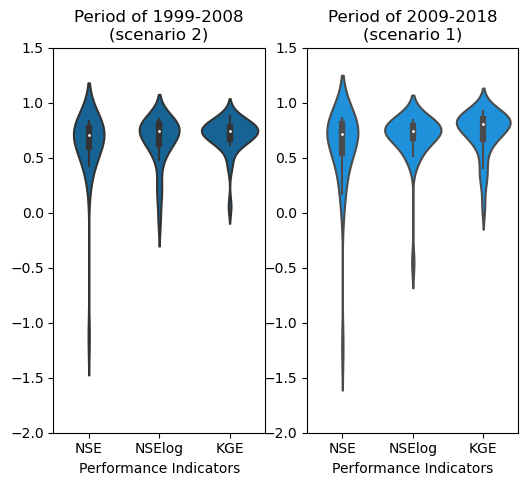

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combineer de gegevens in een pandas DataFrame
data = pd.DataFrame({'Scenario 1 - NSE': NSE_total1, 'Scenario 1 - NSElog': NSE_log_total1, 'Scenario 1 - KGE': KGE_total1,
                     'Scenario 2 - NSE': NSE_total2, 'Scenario 2 - NSElog': NSE_log_total2, 'Scenario 2 - KGE': KGE_total2})

# Maak een figure met twee subplots
fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(6, 5))

# Stel de labels en titels in
labels = ['NSE', 'NSElog', 'KGE']
ax1.set_xlabel('Performance Indicators')
ax2.set_xlabel('Performance Indicators')
# ax1.set_ylabel('Waarden')
# ax2.set_ylabel('Waarden')
ax1.set_title('Period of 2009-2018\n(scenario 1)')
ax2.set_title('Period of 1999-2008\n(scenario 2)')

# Maak de violen
sns.violinplot(data=data.iloc[:, :3], ax=ax1, color=colors[0])
sns.violinplot(data=data.iloc[:, 3:], ax=ax2, color=colors[1])

# Stel de x-as labels in
plt.setp((ax1, ax2), xticks=range(len(labels)), xticklabels=labels)

# Zorg ervoor dat de y-as limieten hetzelfde zijn op beide subplots en van -3 tot 1 gaan
ylim_min = -2
ylim_max = 1.5
ax1.set_ylim(bottom=ylim_min, top=ylim_max)
ax2.set_ylim(bottom=ylim_min, top=ylim_max)

plt.savefig(f'C:/Users/Nienke Tempel/Documents/Thesis/8. Afbeeldingen/performance.pdf')

# Plotje hydrograph

14.314583474784971


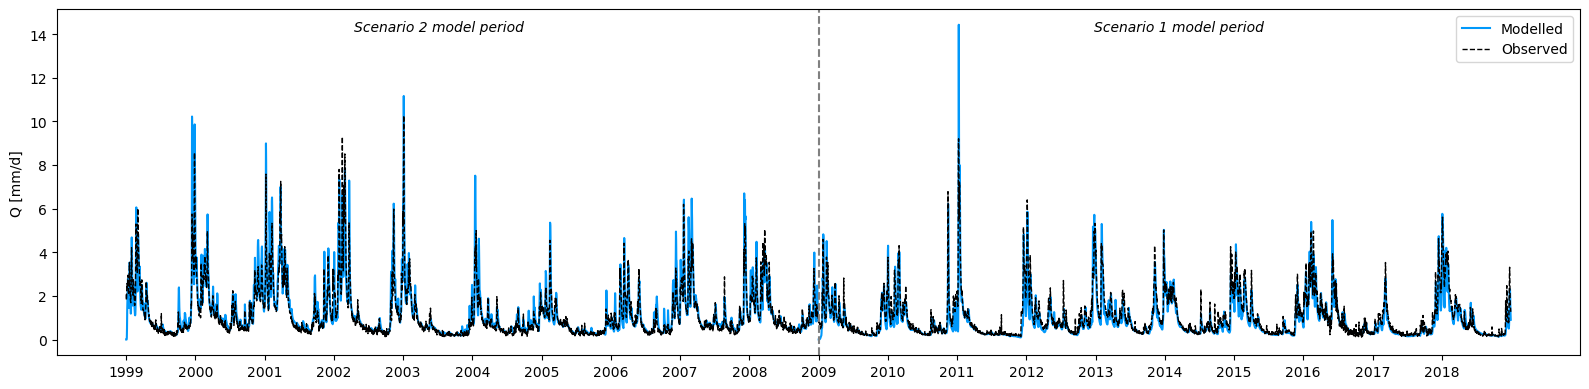

In [28]:
import matplotlib.pyplot as plt

df_output_be1 = df_output_be.loc["2009-01-01":"2018-12-31"]
df_output_be2 = df_output_be.loc["1999-01-01":"2008-12-31"]

df_output_fr1 = df_output_fr.loc["2009-01-01":"2018-12-31"]
df_output_fr2 = df_output_fr.loc["1999-01-01":"2008-12-31"]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16, 4)) # aangepaste grootte

for i in range(len(meuse_names_be_total)):
    if meuse_names_be_total[i] == "Maastricht":
        are = df_area[df_area['Station']==  meuse_names_be_total[i]]
        area = are['area_m2'].item()
        
                    
        Qobs1 = df_output_be1[f"{meuse_names_be_total[i]}"]
        Qobs2 = df_output_be2[f"{meuse_names_be_total[i]}"]
        
        Qsim1 = Q1_sim[f"{meuse_names_be_total[i]}"]
        Qsim2 = Q2_sim[f"{meuse_names_be_total[i]}"]
        
        axs.plot(df_output_be1.index, Qsim1, linestyle='-', linewidth=1.5, color=colors[0], label='Modelled')
        axs.plot(df_output_be2.index, Qsim2, linestyle='-', linewidth=1.5, color=colors[0])
        axs.plot(df_output_be2.index, Qobs2, linestyle='--', color='black', linewidth=1)
        axs.plot(df_output_be1.index, Qobs1, linestyle='--', color='black', label='Observed', linewidth=1)

        # Voeg een horizontale lijn toe op het moment van overgang tussen datasets
        axs.axvline(df_output_be2.index[-1], linestyle='--', color='grey')

        # axs.legend(loc='center right', bbox_to_anchor=(1.0, 0.8), borderaxespad=0.0)
        axs.legend(loc='upper right') # bbox_to_anchor=(1.0, 0.8), borderaxespad=0.0)
        # axs.set_title("Hydrograph Borgharen")
        
        print(max(Qsim1)-min(Qobs1))
        
        # Voeg de tekst toe
        axs.text(df_output_be2.index[1200], 14 , 'Scenario 2 model period', fontsize=10, verticalalignment='bottom', fontstyle='italic')
        axs.text(df_output_be1.index[-1] - pd.Timedelta(days=2200), 14, 'Scenario 1 model period', fontsize=10, verticalalignment='bottom', fontstyle='italic')

        # Stel de xticks in op alle eerste dagen van elk jaar
        # axs.set_xticks(pd.date_range(start=df_output_be2.index[0], end=df_output_be1.index[-1], freq='AS'))
        
        # Maak een lijst met de jaartallen tussen de start- en einddatum van de plot
        years = range(df_output_be2.index.year.min(), df_output_be1.index.year.max()+1)

        # Stel de x-ticklabels in als de jaartallen
        axs.set_xticks([pd.to_datetime(str(y)) for y in years])
        axs.set_xticklabels([str(y) for y in years])
        
        axs.set_ylabel('Q [mm/d]')


plt.tight_layout()
plt.savefig(f'C:/Users/Nienke Tempel/Documents/Thesis/8. Afbeeldingen/hydrograph.pdf')

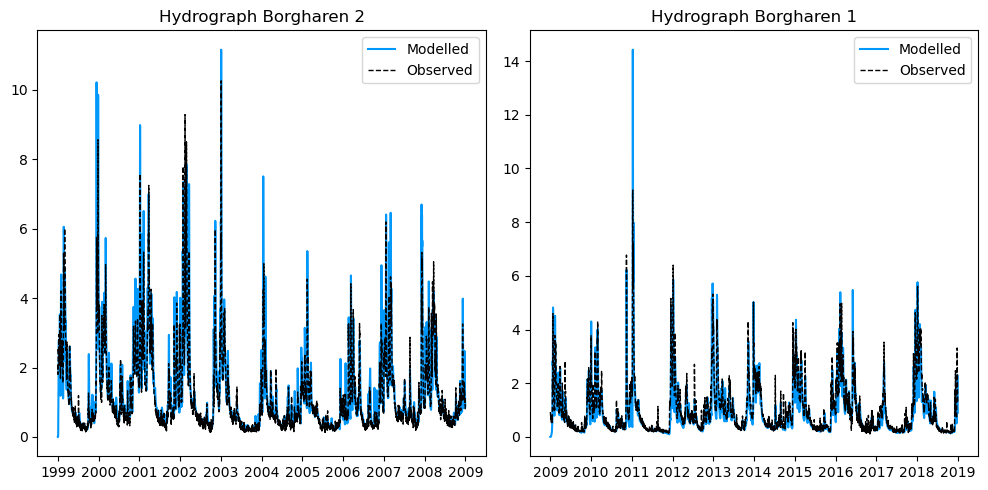

In [22]:
import matplotlib.pyplot as plt


df_output_be1 = df_output_be.loc["2009-01-01":"2018-12-31"]
df_output_be2 = df_output_be.loc["1999-01-01":"2008-12-31"]

df_output_fr1 = df_output_fr.loc["2009-01-01":"2018-12-31"]
df_output_fr2 = df_output_fr.loc["1999-01-01":"2008-12-31"]

for i in range(len(meuse_names_be_total)):
    if meuse_names_be_total[i] == "Maastricht":
        Qobs1 = df_output_be1[f"{meuse_names_be_total[i]}"]
        Qobs2 = df_output_be2[f"{meuse_names_be_total[i]}"]
        
        Qsim1 = Q1_sim[f"{meuse_names_be_total[i]}"]
        Qsim2 = Q2_sim[f"{meuse_names_be_total[i]}"]


        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # twee kolommen voor de twee plotjes

        # plotje 1
        axs[1].plot(df_output_be1.index, Qsim1, linestyle='-', linewidth=1.5, color=colors[0], label='Modelled')
        axs[1].plot(df_output_be1.index, Qobs1, linestyle='--', color='black', label='Observed', linewidth=1)
        axs[1].legend()
        axs[1].set_title("Hydrograph Borgharen 1")

        # plotje 2
        axs[0].plot(df_output_be2.index, Qsim2, linestyle='-', linewidth=1.5, color=colors[0], label='Modelled')
        axs[0].plot(df_output_be2.index, Qobs2, linestyle='--', color='black', label='Observed', linewidth=1)
        axs[0].legend()
        axs[0].set_title("Hydrograph Borgharen 2")

        plt.tight_layout()
        plt.show()


In [21]:
catchment_list = meuse_names_fr
df_output = df_output_fr
yrsl = yrsl_fr
EI_dev_FR = []


descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Interstorm duration', 'Seasonality Timing Index']
descriptors = ['Pa', 'Epa', 'T', 'AI', 'SI', 'is_dur', 'ST']

for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp
        # past decades
        w = df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected past decades {yrsl[j+1]}']] = EI_exp


for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            # past decades
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected past decades {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation past decades {yrsl[j]}']] = EI_dev 
            EI_dev_FR.append(EI_dev)

            
            
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            

df_output_fr = df_output

KeyError: 'La Meuse Goncourt'

In [ ]:
"BE - calculate changes"

catchment_list = meuse_names_be2
df_output = df_output_be
yrsl = yrsl_be

descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Interstorm duration', 'Seasonality Timing Index']
descriptors = ['Pa', 'Epa', 'T', 'AI', 'SI', 'is_dur', 'ST']
EI_dev_BE = []


for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp
        # past decades
        w = df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected past decades {yrsl[j+1]}']] = EI_exp

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            # past decades
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected past decades {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation past decades {yrsl[j]}']] = EI_dev 
            EI_dev_BE.append(EI_dev)
            
            
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            

df_output_be = df_output


In [19]:
"FR - calculate expected Sr"
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
yrsl = yrsl_fr
yrcut = yrcut_fr
df_output = df_output_fr

for i in range(len(catchment_list)):
    print(catchment_list[i])
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]
    # display(data)


    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]    
                    
            #Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            Q  = datanew['dis_subcatch'].mean()

            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P
        
            # Calculate root zone storage deficits
            RP    = 20 #Return-period of 20 years
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

        
            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
 
            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr
                
        
    
# display(df_output)
df_output_fr = df_output

La Meuse Goncourt
Le Mouzon Circourt-sur-Mouzon [Villars]
Le Vair Soulosse-sous-Saint-Élophe
La Meuse Saint-Mihiel
La Meuse Stenay
La Chiers Longlaville
Le Loison Han-lés-Juvigny
La Chiers Carignan
La Bar Cheveuges
La Vence la Francheville


In [20]:
"BE - calculate expected Sr"
warnings.filterwarnings('ignore')
catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_be

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]
            
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]      
        
            # Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P
        
            # Calculate root zone storage deficits
            RP    = 20 #Return-period of 20 years
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD


            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
        
            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr
     

df_output_be = df_output

In [21]:
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
yrsl = yrsl_fr
yrcut = yrcut_fr
df_output = df_output_fr

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            Sr_dev_rel = Sr_dev / Sr
            # Sr_dev_rel = "{:.0%}".format(Sr_dev_rel)
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            df_output.loc[[catchment_list[i]],[f'Sr relative {yrsl[j]}']] = Sr_dev_rel
            
df_output_fr = df_output
            
# display(df_output)

In [22]:
catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_be

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            Sr_dev_rel = Sr_dev / Sr
            # Sr_dev_rel = "{:.0%}".format(Sr_dev_rel)
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            df_output.loc[[catchment_list[i]],[f'Sr relative {yrsl[j]}']] = Sr_dev_rel
            
            
df_output_be = df_output
            
display(df_output)

,AI,EI,Pa,Epa,T,is_dur,SI,ST,Sr,AI 1999 - 2008,...,Pa_change 2009 - 2018,Epa_change 2009 - 2018,T_change 2009 - 2018,AI_change 2009 - 2018,SI_change 2009 - 2018,is_dur_change 2009 - 2018,ST_change 2009 - 2018,Sr expected 2009 - 2018,Sr deviation 2009 - 2018,Sr relative 2009 - 2018
Membre Pont,0.511762,0.441728,1186.161837,607.032565,9.704999,3.858377,0.234389,0.067666,183.898214,0.459068,...,-275.227244,-1.339952,0.202290,0.119220,0.015268,0.042571,0.044705,266.844085,-115.920235,-0.768071
Straimont,0.512991,0.436862,1171.631250,601.036329,9.445414,3.747368,0.223754,0.041235,179.215833,0.459019,...,-279.459689,-1.806657,0.226123,0.122561,0.014736,0.004510,0.060582,266.146580,-119.725646,-0.817681
Treignes,0.636550,0.551366,937.030181,596.466324,9.172218,3.722222,0.217324,0.039243,189.883469,0.606154,...,-89.579959,2.665182,0.130006,0.063844,0.027470,-0.097503,0.037173,222.790345,-29.519268,-0.152735
Chooz,0.658850,0.527555,961.380322,633.405855,9.779350,3.792808,0.186046,0.055677,175.593922,0.604676,...,-164.453842,4.722704,0.185908,0.118482,0.025813,0.236136,-0.015355,207.871085,-44.753684,-0.274365
Daverdisse,0.545536,0.484810,1093.839989,596.728651,10.178251,3.779964,0.175837,0.049095,197.276326,0.495321,...,-226.828657,-2.498539,0.165724,0.112048,0.020617,-0.053218,0.071029,273.836433,-106.697766,-0.638379
Jemelle,0.601484,0.493290,987.412095,593.912515,9.288063,3.729310,0.213731,0.029781,173.375839,0.541819,...,-223.814553,-3.439115,0.150310,0.134583,0.013469,0.042380,0.133387,260.244467,-123.990480,-0.909995
Hastiere,0.749142,0.612772,796.278346,596.525896,9.244202,3.746967,0.176810,0.019015,185.554193,0.715191,...,-77.966346,-1.692020,-0.083484,0.071397,0.055577,-0.014418,0.056337,204.860629,-21.779621,-0.118962
Warnant,0.746131,0.600129,792.368353,591.210802,10.026851,3.891379,0.187355,0.016009,183.782580,0.697196,...,-115.674732,-3.098301,-0.105628,0.105577,0.053092,0.042105,0.067895,205.186174,-23.351520,-0.128422
Ortho,0.580751,0.516111,1021.175809,593.048905,9.931324,3.889655,0.192952,0.037831,196.076731,0.524161,...,-227.534781,-3.689224,0.172584,0.127369,0.017571,0.071253,0.119869,282.667566,-106.572309,-0.605197
Wiheries,0.717729,0.569960,824.441537,591.725647,9.018223,3.696707,0.177207,0.019775,170.672118,0.674940,...,-91.351836,8.896981,0.225334,0.090597,0.029698,0.150477,0.025926,185.012468,-5.197337,-0.028904


In [23]:
print(df_output_fr.keys())
print('halloo----------')
print(df_output_be.keys())

Index(['AI', 'EI', 'Pa', 'Epa', 'T', 'is_dur', 'SI', 'ST', 'Sr',
       'AI 1989 - 1998', 'EI 1989 - 1998', 'Pa 1989 - 1998', 'Epa 1989 - 1998',
       'T 1989 - 1998', 'is_dur 1989 - 1998', 'SI 1989 - 1998',
       'ST 1989 - 1998', 'omega 1989 - 1998', 'Sr actual 1989 - 1998',
       'omega past decades 1989 - 1998', 'AI 1999 - 2008', 'EI 1999 - 2008',
       'Pa 1999 - 2008', 'Epa 1999 - 2008', 'T 1999 - 2008',
       'is_dur 1999 - 2008', 'SI 1999 - 2008', 'ST 1999 - 2008',
       'omega 1999 - 2008', 'Sr actual 1999 - 2008',
       'omega past decades 1999 - 2008', 'AI 2009 - 2018', 'EI 2009 - 2018',
       'Pa 2009 - 2018', 'Epa 2009 - 2018', 'T 2009 - 2018',
       'is_dur 2009 - 2018', 'SI 2009 - 2018', 'ST 2009 - 2018',
       'omega 2009 - 2018', 'Sr actual 2009 - 2018',
       'omega past decades 2009 - 2018', 'EI expected 1999 - 2008',
       'EI expected past decades 1999 - 2008', 'EI expected 2009 - 2018',
       'EI expected past decades 2009 - 2018', 'EI deviation 1999 

In [24]:
df_output_be.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/BE.csv')
df_output_fr.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/FR.csv')

In [25]:
print(meuse_names_fr_total)
print(meuse_names_be_total)

['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Le Loison Han-lés-Juvigny', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville', 'La Sormonne Belval']
['Membre Pont ', 'Sainte-Marie', 'Straimont ', 'Treignes ', 'Chooz ', 'Daverdisse ', 'Jemelle ', 'Gendron ', 'Hastiere', 'Yvoir ', 'Warnant ', 'Modave ', 'Ortho ', 'Mabompre ', 'Tabreux ', 'Wiheries ', 'Salzinnes ', 'Huccorgne ', 'Amay ', 'Martinrive ', 'Chaudfontaine Pisc ', 'Maastricht']


### Determine which ones to exclude

Exclude catchment with ID La Crusnes Pierrepont
Exclude catchment with ID La Crusnes Pierrepont
Exclude catchment with ID Le Ton Écouviez
Exclude catchment with ID La Sormonne Belval
Exclude catchment with ID La Sormonne Belval
Exclude catchment with ID La Sormonne Belval
Exclude catchment with ID (2) Sainte-Marie
Exclude catchment with ID (2) Gendron 
Exclude catchment with ID (2) Yvoir 
Exclude catchment with ID (2) Modave 
Exclude catchment with ID (2) Mabompre 
Exclude catchment with ID (2) Tabreux 
Exclude catchment with ID (2) Martinrive 
Exclude catchment with ID (2) Chaudfontaine Pisc 


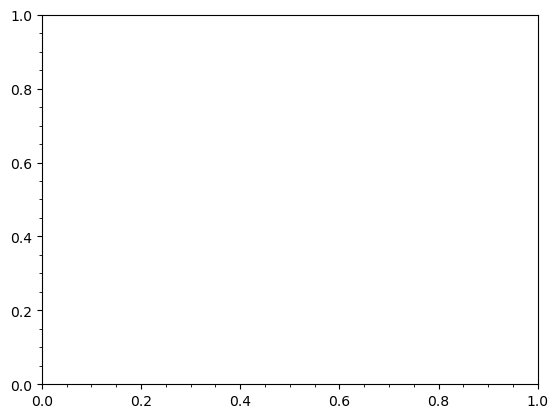

In [26]:
catchment_list = meuse_names_fr_total
yrsl = yrsl_fr
yrcut = yrcut_fr
SRmax_FR = pd.DataFrame()
for i in range(len(catchment_list)):  
    name = fr_dict_code[stations_total[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations_total[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')

    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']

    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()

    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    

    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

    data['year'] = pd.DatetimeIndex(data['dt']).year
    
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs.plot(energy_limit_x, energy_limit_y, c='k')
    axs.plot(budyko_curve_x, water_limit_y,c='k')
    axs.set_ylabel("Actual ET/P")
    axs.set_xlabel("Potential ET/P")
    axs.minorticks_on()
        
    data['year'] = pd.DatetimeIndex(data['dt']).year  
    
    
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        data_past_decades = data.loc[(yrcut[0] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)


        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        axs.plot(AI, EI, marker='o', color=c, label=f'Decade {yrsl[j]}',markersize =10)
        plt.legend()
    
    plt.savefig(f'2_Output/{output}/Budyko/{catchment_list[i]}.png')   
    plt.close(fig)
    


catchment_list = meuse_names_be_total
yrsl = yrsl_be
yrcut = yrcut_be
SRmax_BE = pd.DataFrame()
df_output = df_output_be


for i in range(len(catchment_list)):
    if catchment_list[i] == "Salzines Ronet ":
        catchment_list[i] = "Salzinnes"
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']

    name = catchment_list[i].strip()
    nameupper = name.upper()

    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']

    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    # print(catchment_list[i])
    # print("dataq time range:", dataq["dt"].dt.date.min(), "to", dataq["dt"].dt.date.max())
    # print("data time range:", data["dt"].dt.date.min(), "to", data["dt"].dt.date.max())

    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]

    data['year'] = pd.DatetimeIndex(data['dt']).year
    
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs.plot(energy_limit_x, energy_limit_y, c='k')
    axs.plot(budyko_curve_x, water_limit_y,c='k')
    axs.set_ylabel("Actual ET/P")
    axs.set_xlabel("Potential ET/P")
    axs.minorticks_on()
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        data_past_decades = data.loc[(yrcut[0] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        axs.plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize =10)

    
    plt.savefig(f'2_Output/{output}/Budyko/{catchment_list[i]}.png')   
    plt.close(fig)

In [27]:
yrsl = yrsl_fr

for j in range(len(yrsl)):
    if j > 1:
        for i in range(len(df_output_fr)):
            catch_dat = df_output_fr.iloc[i]
            idx = df_output_fr.index[i]
            wflow = WFLOW[idx]
            EI_dev = catch_dat[f'EI deviation {yrsl[j]}']
                
            print(wflow, "{:.2f}".format(EI_dev))

                
yrsl = yrsl_be

for j in range(len(yrsl)):
    if j > 0:
        for i in range(len(df_output_be)):
            catch_dat = df_output_be.iloc[i]
            idx = df_output_be.index[i]
            wflow = WFLOW[idx]
            EI_dev = catch_dat[f'EI deviation {yrsl[j]}']
                
            print(wflow, "{:.2f}".format(EI_dev))

1011 0.02
1013 -0.05
1016 -0.05
101 -0.01
3 -0.03
203 -0.21
209 -0.18
201 -0.18
41 -0.10
42 -0.06
5 -0.15
501 -0.15
6 -0.04
4 -0.10
802 -0.12
803 -0.17
701 -0.03
703 -0.04
1002 -0.14
903 -0.01
9 -0.05
13 -0.05
1401 -0.11
16 -0.09


In [27]:
EI_dev_total = EI_dev_FR + EI_dev_BE
print(len(EI_dev_total))

34


In [28]:
EI_dev_GB = [-0.045627187389284674, -0.020016417324452973, -0.02049490034211543, 0.0022180625575519697, 0.010111275804096598, -0.0167125928569693, 0.03848854957869363, 0.03225861440694233, 0.0037526295327623416, -0.026235902809177078, -0.0022377904620548006, 0.028928228776468834, -0.03345410306245522, 0.022270902930456637, -0.060158121783352225, -0.018440689696385015, 0.005658551367740017, -0.004350062523560072, 0.0037685829870406917, 0.029245678483859006, 0.02788893910261253, 0.007686528915106516, 0.04362992576123814, 0.03312121200056534, -0.06199650120303746, 0.05177753899999349, 0.02024816819433034, -0.03294547227524949, 0.003611105233681189, -0.0031304928626904593, -0.03291468876098547, 0.07906853812174863, -0.07433149572555597, -0.04771381223506593, -0.05247806728206994, -0.04815420246961605, -0.01177931701625895, 0.025000404105228413, 0.004841708170629788, 0.0662179017608631, 0.05984339982671055, 0.08006428620162925, 0.005116878322012575, 0.03727973199293455, 0.01929190207261733, -0.003886024122076448, 0.02064155467391321, -0.033663692273440626, -0.013107406323050685, 0.020507116216416876, -0.005851129038536573, 0.007439900996392135, -0.0218482935696932, 0.02056570144523806, -0.033437978530268975, 0.0473653777712395, 0.0010483609360257828, 0.035253264378144245, 0.021318418583404775, 0.0067972939497352725, -0.010305225421992747, 0.04503399139343789, 0.014094602708828563, 0.009244025835244085, 0.059627714028833934, 0.08378769352510129, 0.07745276765388498, 0.014038451795356233, 0.023353171025036756, 0.022653932757544792, 0.0002013306757909783, 0.050227232935874944, -0.024014482558023187, -0.01652974181922362, -0.007396193797841177, 0.03680827245019547, 0.034640532350609154, -0.0026814780734105703, 0.0033095672478434812, 0.01645361909702403, 0.0032975261317411686, 0.023401349811414618, 0.04490890051706631, 0.012155337297732993, 0.02936227134278968, 0.024419694354105626, 0.018042417624897444, 0.015214233380732134, 0.013941190040182017, -0.010872482235592895, -0.0012497440804480897, 0.026144952234466445, -0.030185585787865676, 0.008938659529407644, 0.011455263529252746, -0.0007612757096213674, 0.005978933258644958, 0.006754159828421313, 0.003505196157996937, 0.09351547990005205, 0.025611315351253605, -0.0076970402666465265, -0.010236457284969247, 0.045330975929213646, 0.009209004929188858, 0.006773669231423973, 0.00014281366848079013, -0.014650834027590709, -0.035070179471233365, -0.004888550614383647, -0.034859687070469214, 0.011802652551751835, -0.01736577461787825, -0.003352019399359585, -0.01227694972754878, 0.007709682392526562, 0.003109575949900689, 0.03652290704600425, 0.0036724357526789486, -0.014682345043098621, 0.024067989916502164, 0.04265377321656039, 0.006377640032394272, -0.0016303989029805566, -0.006885365862791981, 0.016250138118005575, 0.006414862823660883, -0.01856612030756888, -0.06160627518705952, 0.05077970963464329, 0.01930688517204915, -0.007352927716737456, -0.0022513926551471775, 0.03718042281585121, 0.038810992192221616, -0.025998358221175133, -0.0009558817213284332, -0.051083190477798635, -0.0015840876559086725, -0.00738010127945643, 0.0066269547576871535, 0.008450888834667825, 0.007886768735715699, -0.012641152894775687, 0.033545970081603205, 0.018237894992991888, -0.0034891642456346406, 0.008985431896398832, -0.016187615611541334, -0.022218791104821445, 0.00935847505250298, -0.007998182052376346, 0.037980937697584094, 0.0029534463472923878, 0.0129550189973624, -0.006695116741024909, 0.004034262634525165, 0.0021245414993876777, 0.0004665141845347498, 0.004151008980930515, -0.0026023442666136543, -0.031073916333927754, -0.005027464639746293, -0.002998144907396749, -0.0018034249255575174, 0.0018838755684966735, 0.014876741812696381, -0.018392338290579624, -4.538151555888437e-05, 0.0017963095558305442, 0.009388116532726976, 0.030060674503877727, 0.019115918965353584, 0.0020591855780761614, -0.0012960291354153775, 0.016678389110430736, 0.019839035899748336, -0.033195374592090376, -0.005865612196273795, -0.013638032555908342, -0.011589178486778429, 0.03254206883653499, 0.04752026013195976, -0.03281839528249564, 0.0064246025117591365, -0.002313623885678351, 0.00971543732054947, 0.021248035478183325, 0.029687932402889694, -0.02549360760441033, 0.03568327055879883, 0.054071872991727166, 0.0019426181248068941, 0.03749927570998812, 0.05787864790536934, -0.01814410671356881, -0.024161197665240053, -0.018365858120236278, 0.0044394300871991865, 0.011519529062809536, 0.0046945687899467015, -0.00023983220475126688, 0.038797506429722906, 0.06619581133694658, -0.0635991236462844, 0.04912117445214803, 0.02293737014253916, -0.016985122440747208, 0.0036703711653776616, 0.01077476663644164, 0.008542121866992547, -0.00540516967860466, 0.008734293453849074, -0.03073234034978195, 0.0019165483722152765, 0.0508977238992564, -0.010011428980591264, 0.02165802441114556, 0.015067027192313953, 0.010731778934806313, 0.018124583273898542, -0.06343821406415856, 0.009530437141875236, 0.003174143914493943, -0.046376475058348604, 0.004494613041881479, 0.013386144162791658, -0.033750976681205996, 0.006447297070164282, 0.023061366060512206, 0.013314668965837523, 0.03408991145373297, 0.02059383277417992, -0.028727944098174696, 0.013259899514946355, -0.039992840196697244, 0.0009093405024322432, 0.036765136787236585, 0.04565693234997578, 0.06318104450503256, 0.02351879070698093, -0.008539145055304065, -0.023960833290281203, 0.00012044036123981527, -0.024860719979663715, -0.01581755258858364, -0.01964161789227198, -0.00607440407281945, 0.022710903193497722, -0.010460857738063961, -0.07209613521214053, -0.036889795520930885, -0.03055626202733172, -0.00466440655757952, -0.00601395381673997, -0.010018669592636309, -0.026285559353771137, -0.010983572894405907, 0.009310197377601304, 0.03549271738342363, 0.018795706366331877, -0.035033015195047285, 0.01077872427469348, 0.002005885300449012, 0.32992853151860907, 0.1039248881644454, 0.05407195552351751, -0.028676545719987206, -0.007222395124686837, -0.012261188083140029, -0.017759145496316547, -0.002831844672254724, 0.014704556194399976, -0.005833056662658792, 0.009417622490127814, 0.004469859312623142, -0.00916525788998307, 0.040415726392095896, 0.012384412932760158, 0.1488146688889881, 0.05299701099513096, 0.03967681175396748, -0.027779639368245845, 0.008546189042599017, 0.014826845670142627]
print(len(EI_dev_GB))

285


In [29]:
EI_dev_USA  = [0.027565127761743136, 0.0848671902344792, -0.007442988159922503, 0.04109754585385961, -0.008185955578576487, 0.02317351844124982, -0.05305432994862325, 0.00566849961590421, -0.010013506775980896, -0.006528622777131399, 0.0031508944684305318, 0.004821735101648961, -0.022622286066683706, 0.0388828040891408, -0.020317786890316825, 0.07135818794380366, -0.010791256819830508, 0.042514884066714886, -0.009121846207206907, 0.04076203044709281, 0.012789536957901415, 0.04497479919558156, -0.010698013991373045, 0.049738071210069235, -0.010352618817307424, 0.04164569058366541, -0.021934267868327195, 0.020090790448363816, -0.029329550091717227, 0.04552661408312997, -0.028027958371993122, 0.06424371779972571, -0.030163306238429888, 0.04659035902174935, -0.021920014809797217, 0.03426162005394451, -0.010672462339032851, 0.08029743008623214, 0.005242589289273347, 0.05952391266854862, -0.0323862639157414, 0.06992145787954229, -0.02177086640294923, 0.07018697601482082, -0.10302573578405977, 0.08991283282902218, -0.06991070787255238, 0.07329401448709782, -0.06517686641961373, 0.03094834495206733, 0.04498335572974599, -0.00025129504357335186, 0.028885619782272776, -0.026964373450438117, 0.0005515973873454483, 0.004441887123604049, 0.002760450125315117, -0.0021766912647901426, 0.005598222628352079, 0.05643128070015624, 0.005997335026803774, 0.03088121663458887, 0.01933551714610171, 0.05060442034006307, 0.01968409174725494, 0.05071720969654203, -0.050103390314980345, 0.08064020719004727, -0.01107799892671224, 0.07216912488150107, 0.04114663129124729, 0.04768974723970987, 0.025707255253987538, 0.006054501482523289, -0.01522157315636452, 0.009562750166335898, 0.0059871585246027426, 0.02744032821990139, 0.02441158984789782, 0.024499904066910827, 0.02336838897604976, 0.026662538334463304, -0.047120810120262924, 0.07238258043290724, -0.023307291008146103, 0.05497197747969185, 0.01367224844331405, 0.017142212931747225, -0.030990339439634695, 0.04552595129169956, 0.008786736107415982, 0.053105710695209085, -0.026693794495915246, 0.03517591264227993, -0.006430248138299066, 0.02757208645834286, -0.014639062597378238, 0.0032315663363647884, -0.001829392570202537, 0.05669119293942293, 0.002812302281352763, 0.021798081439356687, 0.014891337156269557, 0.05430394227975344, -0.011296031767286552, -0.0011741020077041808, 0.0069432831349655055, 0.032456653497582755, -0.031231763663511547, -0.006602215792317456, -0.016677243540609288, 0.0509685805201614, -0.03135438302829574, 0.06692517971171275, -0.013332520064213926, 0.05951998548764603, -0.02916516406900682, 0.01577027562214084, -0.04546999959360476, 0.08588852100321676, -0.027494788521744917, 0.013371690270652992, -0.02877571631303133, 0.0529820231028878, 0.00396021817518688, 0.06792178436574403, -0.022103006686459814, 0.01295203193137029, -0.07230446132378021, 0.04608124221966614, 0.03334394451344447, 0.030177368578668817, 0.04237704661760222, 0.03136138667188093, 0.0012413575629424134, 0.03351000353227107, 0.016066989517452668, 0.016720784522573084, 0.02295433941044489, 0.019281674358407552, 0.022464490390601277, 0.04562796652313594, 0.022196714195107936, 0.042228062819792966, 0.00023890879193677605, 0.032467889290226704, -0.024650061923469746, 0.037656708138151807, -0.04149581677463421, 0.047985178128768236, 0.048659887623003883, -0.01831575469469182, -0.02071297255113691, 0.03386649833427924, -0.05083955631748016, 0.0018372562096966583, 0.02595434812755837, 0.0164924154554138, 0.014671921978341551, -0.006922120119627673, -0.003083791269512526, 0.035410071811863064, -0.01776889293844197, 0.017265603950247455, -0.013021372115260998, -0.010559294085407123, -0.05430802471906315, -0.020543068714259594, -0.024021023362278737, 0.04258727229550663, -0.03601168016950429, 0.004679968879549912, -0.007487029873486706, 0.01917201502559629, 0.004010698434764759, 0.05112758441300158, -0.023694773374261735, 0.04544522780508864, -0.01116570645117887, 0.016627629701135405, -0.04694987443578652, 0.062164921070557655, -0.04958531772169983, 0.05018061901187881, -0.06335347890781673, 0.0027286181336405035, -0.0638664388310739, -0.014138936142612302, 0.0729169851917405, 0.06685639071856608, 0.03938768303026563, 0.055393956417944756, 0.0254215352455629, 0.03909510743037348, -0.026372267079617706, 0.061610699854469875, 0.02940478714586825, 0.005972276343357619, -0.02463188361769819, -0.04773005945193415, -0.009433905300126, 0.04590435850273378, 0.028525006680491072, 0.011520683780582242, -0.03639269593995431, -0.028599903795747394, -0.008481549477704853, 0.058623608768028856, -0.0076844074055787415, 0.05820827324112243, 0.023031128134673784, 0.06318974036888714, -0.016423902014531366, 0.056378834037609904, 0.019120140770921945, 0.1027007954482958, -0.03957365246486122, 0.09975583372465979, -0.0016848141145520135, 0.0001320425099593514, 0.035691643459019984, 0.0514874933403725, -0.03340763203065489, 0.04658960682571178, 0.0012443350079109905, 0.04699507496525346, 0.004965685252197205, 0.012118932004973493, 0.008121211643445592, 0.04398231559448895, -0.04964116945891828, -0.023314205456997583, 0.03989568205371696, 0.07604051118688937, -0.011141271809665731, 0.05007149375204378, 0.0042325467380115445, -0.0037680087123221906, 0.056702999970364654, 0.06324657614199036, 0.03140549893715261, 0.04693279704026432, 0.023484790973552272, 0.021258571545486382, -0.0033028016134650784, 0.0550559186688947, 0.005857705982115102, 0.05310934850016469, -0.02774397393796968, 0.028443753248166503, -0.014331618293585202, 0.09206458396030148, -0.014880624476783177, 0.023044252357009687, -0.018224495026516907, 0.07156389063729363, 0.04358429278420539, 0.04939877224384159, 0.026629957094072565, 0.05153792460665518, 0.028043811241903138, 0.03660739907585542, 0.002295995647819127, 0.06238908800322829, 0.03155132613932221, 0.027660566519357, 0.018402164378066854, 0.014994596916984793, -0.03702572380225022, 0.017881489721539356, -0.0003277855919265882, 0.04945644222098977, 0.03830098138201499, 0.017338078086613806, 0.027455671064055, 0.08344906538661168, 0.020220074292252255, 0.10209354171166707, 0.02456724605072691, 0.06564364466402373, -0.014398588650449518, 0.04163666916622355, 0.03197936505671051, 0.0904074514157216, 0.014873830602346483, 0.04575343176896218, 0.026144306040107756, 0.04860899362889248, 0.02507332803093909, 0.048694453931988124, -0.00567307248688953, 0.005045677392627623, -0.020077654588956273, 0.01188459199602665, -0.005345674049676452, 0.007426731710259871, -0.017978255748275496, 0.011614512409256927, -0.012618772544204626, -0.00043661329496325063, -9.828485766283368e-05, -0.0560013871918692, -0.03372240716268582, 0.0073439753076876, -0.00019721457021748545, 0.025008914666295068, -0.006639502636793249, 0.01857449389436694, -0.012203320204341339, 0.02161710647229209, -0.0056610955067314395, 0.04343399167508433, 0.004049063398415043, 0.07116806665353792, 0.016388079143017764, 0.025108420550376098, -0.019648770897567336, 0.002751101398042022, -0.006813415815022261, 0.0012963742078534457, 0.007911908152484881, 0.0455858104288247, 0.0002632459821430011, 0.06484292045362106, -0.049858680270819966, 0.14347020963768375, 0.01682538420284485, 0.05142142604893396, -0.02552753433920585, 0.056807503762608125, 0.025881028303333276, 0.05026732089118979, 0.014254156217105574, -0.002744786558453449, -0.006856196486214827, 0.027690079801305, 0.009328311033745762, 0.020127005902645823]
print(len(EI_dev_USA))

338


In [30]:
EI_dev_combined = EI_dev_total + EI_dev_GB + EI_dev_USA 
print(EI_dev_combined)

[-0.01878173667803751, 0.011551250985167738, 3.57358468209279e-05, -0.053021286642643495, -0.016344718253714086, -0.05697579334768521, 0.02254211717947452, 0.0026621416864553993, 0.00209345465935451, -0.03277699100980369, -0.0061819635288618, -0.2009426685757864, 0.004224760572106301, -0.1794197364118656, -0.007741950141103016, -0.1840965515667835, 0.001963634868214603, -0.09834383370319866, 0.0040794698271158225, -0.05409013762049797, -0.14976892838565992, -0.14765447523554498, -0.0444218526675787, -0.09778086849750578, -0.12458782468931623, -0.1709000427476539, -0.03363627193381158, -0.035056668005021496, -0.1398667416036038, -0.007932157273164875, -0.04766552213802433, -0.053203745769737854, -0.10953870936475008, -0.09118730565252475, -0.045627187389284674, -0.020016417324452973, -0.02049490034211543, 0.0022180625575519697, 0.010111275804096598, -0.0167125928569693, 0.03848854957869363, 0.03225861440694233, 0.0037526295327623416, -0.026235902809177078, -0.0022377904620548006, 0.0289

In [31]:
EI_dev_total_array = np.array(EI_dev_total)  

EI_dev_total_list = list(EI_dev_total_array)  
EI_dev_total_inv = [-1.0 * x for x in EI_dev_total_list]
# print(EI_dev_total_inv)

In [32]:
EI_dev_total_combined_array = np.array(EI_dev_combined)  

EI_dev_total_combined_list = list(EI_dev_total_combined_array)  
EI_dev_total_combined_inv = [-1.0 * x for x in EI_dev_total_combined_list]
# print(EI_dev_total_combined_inv)

### Nu echte base case (alleen tweede eeuw) - prediction 1

In [34]:
catchment_list = meuse_names_fr_total
warnings.filterwarnings('ignore')
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_fr
SRmax_FR = pd.DataFrame()
SRmax_BE = pd.DataFrame()

for i in range(len(catchment_list)):
    name = fr_dict_code[stations_total[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations_total[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            #Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            Q  = datanew['dis_subcatch'].mean()
        
            # Compute actual evaporation and Evaporative Index and Aridity index
            Ea = P - Q  # actual evaporation
            AI = Ep / P   # aridity index
            EI = Ea / P # evaporative index
            
            # Calculate root zone storage deficits
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']
            
            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))
            
            if catchment_list[i] in meuse_names_fr:
                w = df_output.loc[catchment_list[i],[f'omega {yrsl[0]}']].item()
                EI_exp = w_function(AI, w)
                Ea = EI_exp * P

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr_2 = rootzone(df_out,2)[0]
            Sr_20 = rootzone(df_out,20)[0]
            
            SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
            SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20
            
 

warnings.filterwarnings('ignore')
catchment_list = meuse_names_be_total
df_output = df_output_be

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]
            
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            #Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            Q  = datanew['dis_subcatch'].mean()
        
            # Compute actual evaporation and Evaporative Index and Aridity index
            Ea = P - Q  # actual evaporation
            AI = Ep / P   # aridity index
            EI = Ea / P # evaporative index
            
            # Calculate root zone storage deficits
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']
            
            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))
            
            if catchment_list[i] in meuse_names_be2:
                w = df_output.loc[catchment_list[i],[f'omega {yrsl[0]}']].item()
                EI_exp = w_function(AI, w)
                Ea = EI_exp * P

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr_2 = rootzone(df_out,2)[0]
            Sr_20 = rootzone(df_out,20)[0]
            
            SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
            SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20
            
SRmax = pd.concat([SRmax_BE, SRmax_FR])
SRmax_WFLOW = pd.DataFrame(columns = [f'WFLOW', f'Sr_2', f'Sr_20'])
for i in range(len(SRmax)):
    name = SRmax.index[i]
    wflow = WFLOW[name]
    subcatch = SRmax.iloc[i]
    Sr_2 = subcatch[f'Sr_2 {yrsl[1]}']
    Sr_20 = subcatch[f'Sr_20 {yrsl[1]}']
    SRmax_WFLOW.loc[i, 'WFLOW'] = wflow
    SRmax_WFLOW.loc[i, f'Sr_2'] = Sr_2
    SRmax_WFLOW.loc[i, f'Sr_20'] = Sr_20
display(SRmax_WFLOW)

# SRmax_WFLOW.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRfirst/SRmax3_0.csv', index=False)

,WFLOW,Sr_2,Sr_20
0,1011,117.755084,216.588957
1,1013,131.714538,226.75398
2,1016,116.338252,202.217791
3,101,105.118772,189.245065
4,3,103.279267,182.97613
5,203,180.317968,298.416029
6,206,123.707847,204.957718
7,207,94.714422,164.120052
8,209,183.508723,281.188596
9,201,171.81252,270.43412


#### Calculate expected Srmax - with sample (Both datasets) - Prediction 1

In [33]:
# for s in range(51):
    # print(s)
    # print(s+50)

In [35]:
for s in range(1):
    SRmax_FR = pd.DataFrame()
    SRmax_BE = pd.DataFrame()
    catchment_list = meuse_names_fr_total
    warnings.filterwarnings('ignore')
    yrsl = yrsl_be
    yrcut = yrcut_be
    df_output = df_output_fr

    for i in range(len(catchment_list)):
        name = fr_dict_code[stations_total[i]]
        df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations_total[i]]
        df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
        df_station.index = df_station['dt']
        df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
        dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
        dataq_fr = dataq_fr.dropna(axis='rows')

        data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        data.loc[:,'dt'] = pd.to_datetime(data['dt'])
        data.index = data['dt']

        namefr = fr_dict_inv[name]  
        are = df_area[df_area['Station']== namefr]
        area = are['area_m2'].item()

        dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
        dataq_fr_day = dataq_fr.resample('D').sum() 
        dataq_fr_day["day"] = dataq_fr_day["hour"]
        dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
        dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area

    #    Get the right dates (1996 - 2016)
        data = data.loc["1989-01-01":"2018-12-31"]
        data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

        # Seperate data into slices
        data['year'] = pd.DatetimeIndex(data['dt']).year
        for j in range(len(yrsl)):
            if j > 0:
                datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
                #Compute the Makkink potential evaporation
                Ep = datanew['epot_subcatch'].mean()    
                T = datanew['temp_subcatch'].mean()
                P  = datanew['prec_subcatch'].mean()
                Q  = datanew['dis_subcatch'].mean()

                # Compute actual evaporation and Evaporative Index and Aridity index
                Ea = P - Q  # actual evaporation
                AI = Ep / P   # aridity index
                EI = Ea / P # evaporative index

                # Calculate root zone storage deficits
                P_ts  = datanew['prec_subcatch']
                EP_ts = datanew['epot_subcatch']

                Et = np.zeros(len(P_ts))
                SD = np.zeros(len(P_ts))

                if catchment_list[i] in meuse_names_fr:
                    w = df_output.loc[catchment_list[i],[f'omega {yrsl[0]}']].item()
                    EI_exp = w_function(AI, w)
                    EI_sample = EI_exp + random.sample(EI_dev_combined, k=1)[0]
                    Ea = EI_sample * P

                for z in range(len(P_ts)):
                    Et[z] = (EP_ts[z]/Ep) * Ea
                    if z == 0:
                        SD[z] = min(0, P_ts[z] - Et[z])
                    else:
                        SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
                datanew.loc[:,'SD'] = SD

                datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
                df_out = pd.DataFrame(index = datanew.index)
                df_out['hydroyear'] = datanew['year']
                df_out['SD_sum'] = datanew['SD']
                Sr_2 = rootzone(df_out,2)[0]
                Sr_20 = rootzone(df_out,20)[0]

                SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
                SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20



    warnings.filterwarnings('ignore')
    catchment_list = meuse_names_be_total
    df_output = df_output_be

    for i in range(len(catchment_list)):
        # Import data and select right dates
        data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        data.loc[:,'dt'] = pd.to_datetime(data['dt'])
        data.index = data['dt']

        name = catchment_list[i].strip()
        nameupper = name.upper()

        # Read Belgian data        
        dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        dataq.columns = ['dt', 'Q']
        dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
        dataq.index = dataq['dt']

        if name == "Salzinnes":
            name = "Salzinnes Ronet"
        are = df_area[df_area['Station']== name]
        area = are['area_m2'].item()

        if catchment_list[i] !=  "Maastricht":
            dataq["hour"] = dataq["Q"] * 3600
            dataq_day = dataq.resample('D').sum() 
            dataq_day["day"] = dataq_day["hour"]
            dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
            dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
        else:
            dataq_day = dataq
            dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
            dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area


        # get the right dates (1996 - 2016)
        data = data.loc["1999-01-01":"2018-12-31"]
        data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]


        # Seperate data into slices
        data['year'] = pd.DatetimeIndex(data['dt']).year
        for j in range(len(yrsl)):
            if j > 0:
                datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
                #Compute the Makkink potential evaporation
                Ep = datanew['epot_subcatch'].mean()    
                T = datanew['temp_subcatch'].mean()
                P  = datanew['prec_subcatch'].mean()
                Q  = datanew['dis_subcatch'].mean()

                # Compute actual evaporation and Evaporative Index and Aridity index
                Ea = P - Q  # actual evaporation
                AI = Ep / P   # aridity index
                EI = Ea / P # evaporative index

                # Calculate root zone storage deficits
                P_ts  = datanew['prec_subcatch']
                EP_ts = datanew['epot_subcatch']

                Et = np.zeros(len(P_ts))
                SD = np.zeros(len(P_ts))

                if catchment_list[i] in meuse_names_be2:
                    w = df_output.loc[catchment_list[i],[f'omega {yrsl[0]}']].item()
                    EI_exp = w_function(AI, w)
                    EI_sample = EI_exp + random.sample(EI_dev_combined, k=1)[0]
                    Ea = EI_sample * P

                for z in range(len(P_ts)):
                    Et[z] = (EP_ts[z]/Ep) * Ea
                    if z == 0:
                        SD[z] = min(0, P_ts[z] - Et[z])
                    else:
                        SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
                datanew.loc[:,'SD'] = SD

                datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
                df_out = pd.DataFrame(index = datanew.index)
                df_out['hydroyear'] = datanew['year']
                df_out['SD_sum'] = datanew['SD']
                Sr_2 = rootzone(df_out,2)[0]
                Sr_20 = rootzone(df_out,20)[0]

                SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
                SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20

    SRmax = pd.concat([SRmax_BE, SRmax_FR])
    SRmax_WFLOW = pd.DataFrame(columns = [f'WFLOW', f'Sr_2', f'Sr_20'])
    for i in range(len(SRmax)):
        name = SRmax.index[i]
        wflow = WFLOW[name]
        subcatch = SRmax.iloc[i]
        Sr_2 = subcatch[f'Sr_2 {yrsl[1]}']
        Sr_20 = subcatch[f'Sr_20 {yrsl[1]}']
        SRmax_WFLOW.loc[i, 'WFLOW'] = wflow
        SRmax_WFLOW.loc[i, f'Sr_2'] = Sr_2
        SRmax_WFLOW.loc[i, f'Sr_20'] = Sr_20
    # SRmax_WFLOW.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRB1/SRmax{s+40}.csv', index=False)

### Nu echte base case (alleen eerste eeuw) prediction 2

In [36]:
catchment_list = meuse_names_fr_total
warnings.filterwarnings('ignore')
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_fr
SRmax_FR = pd.DataFrame()
SRmax_BE = pd.DataFrame()

for i in range(len(catchment_list)):
    name = fr_dict_code[stations_total[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations_total[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j == 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            #Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            Q  = datanew['dis_subcatch'].mean()
        
            # Compute actual evaporation and Evaporative Index and Aridity index
            Ea = P - Q  # actual evaporation
            AI = Ep / P   # aridity index
            EI = Ea / P # evaporative index
            
            # Calculate root zone storage deficits
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']
            
            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))
            
            if catchment_list[i] in meuse_names_fr:
                w = df_output.loc[catchment_list[i],[f'omega {yrsl[1]}']].item()
                EI_exp = w_function(AI, w)
                Ea = EI_exp * P

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr_2 = rootzone(df_out,2)[0]
            Sr_20 = rootzone(df_out,20)[0]
            
            SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
            SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20
            
 

warnings.filterwarnings('ignore')
catchment_list = meuse_names_be_total
df_output = df_output_be

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]
            
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j == 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            #Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            Q  = datanew['dis_subcatch'].mean()
        
            # Compute actual evaporation and Evaporative Index and Aridity index
            Ea = P - Q  # actual evaporation
            AI = Ep / P   # aridity index
            EI = Ea / P # evaporative index
            
            # Calculate root zone storage deficits
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']
            
            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))
            
            if catchment_list[i] in meuse_names_be2:
                w = df_output.loc[catchment_list[i],[f'omega {yrsl[1]}']].item()
                EI_exp = w_function(AI, w)
                Ea = EI_exp * P

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr_2 = rootzone(df_out,2)[0]
            Sr_20 = rootzone(df_out,20)[0]
            
            SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
            SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20
            
SRmax = pd.concat([SRmax_BE, SRmax_FR])
SRmax_WFLOW = pd.DataFrame(columns = [f'WFLOW', f'Sr_2', f'Sr_20'])
for i in range(len(SRmax)):
    name = SRmax.index[i]
    wflow = WFLOW[name]
    subcatch = SRmax.iloc[i]
    Sr_2 = subcatch[f'Sr_2 {yrsl[0]}']
    Sr_20 = subcatch[f'Sr_20 {yrsl[0]}']
    SRmax_WFLOW.loc[i, 'WFLOW'] = wflow
    SRmax_WFLOW.loc[i, f'Sr_2'] = Sr_2
    SRmax_WFLOW.loc[i, f'Sr_20'] = Sr_20
display(SRmax_WFLOW)

# SRmax_WFLOW.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRA2/SRmax_0.csv', index=False)

,WFLOW,Sr_2,Sr_20
0,1011,108.145573,195.622597
1,1013,88.402887,159.818714
2,1016,78.815203,149.760675
3,101,80.453064,149.38568
4,3,73.270293,131.196347
5,203,78.779531,135.47402
6,206,183.707085,294.948128
7,207,167.950904,251.299994
8,209,88.761163,142.695343
9,201,81.826289,135.001309


#### Calculate expected Srmax - with sample (Both datasets) - Prediction 2

In [38]:
for s in range(101):
    SRmax_FR = pd.DataFrame()
    SRmax_BE = pd.DataFrame()
    catchment_list = meuse_names_fr_total
    warnings.filterwarnings('ignore')
    yrsl = yrsl_be
    yrcut = yrcut_be
    df_output = df_output_fr

    for i in range(len(catchment_list)):
        name = fr_dict_code[stations_total[i]]
        df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations_total[i]]
        df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
        df_station.index = df_station['dt']
        df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
        dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
        dataq_fr = dataq_fr.dropna(axis='rows')

        data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        data.loc[:,'dt'] = pd.to_datetime(data['dt'])
        data.index = data['dt']

        namefr = fr_dict_inv[name]  
        are = df_area[df_area['Station']== namefr]
        area = are['area_m2'].item()

        dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
        dataq_fr_day = dataq_fr.resample('D').sum() 
        dataq_fr_day["day"] = dataq_fr_day["hour"]
        dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
        dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area

    #    Get the right dates (1996 - 2016)
        data = data.loc["1989-01-01":"2018-12-31"]
        data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

        # Seperate data into slices
        data['year'] = pd.DatetimeIndex(data['dt']).year
        for j in range(len(yrsl)):
            if j == 0:
                datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
                #Compute the Makkink potential evaporation
                Ep = datanew['epot_subcatch'].mean()    
                T = datanew['temp_subcatch'].mean()
                P  = datanew['prec_subcatch'].mean()
                Q  = datanew['dis_subcatch'].mean()

                # Compute actual evaporation and Evaporative Index and Aridity index
                Ea = P - Q  # actual evaporation
                AI = Ep / P   # aridity index
                EI = Ea / P # evaporative index

                # Calculate root zone storage deficits
                P_ts  = datanew['prec_subcatch']
                EP_ts = datanew['epot_subcatch']

                Et = np.zeros(len(P_ts))
                SD = np.zeros(len(P_ts))

                if catchment_list[i] in meuse_names_fr:
                    w = df_output.loc[catchment_list[i],[f'omega {yrsl[1]}']].item()
                    EI_exp = w_function(AI, w)
                    EI_sample = EI_exp + random.sample(EI_dev_total_inv, k=1)[0]
                    Ea = EI_sample * P

                for z in range(len(P_ts)):
                    Et[z] = (EP_ts[z]/Ep) * Ea
                    if z == 0:
                        SD[z] = min(0, P_ts[z] - Et[z])
                    else:
                        SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
                datanew.loc[:,'SD'] = SD

                datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
                df_out = pd.DataFrame(index = datanew.index)
                df_out['hydroyear'] = datanew['year']
                df_out['SD_sum'] = datanew['SD']
                Sr_2 = rootzone(df_out,2)[0]
                Sr_20 = rootzone(df_out,20)[0]

                SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
                SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20



    warnings.filterwarnings('ignore')
    catchment_list = meuse_names_be_total
    df_output = df_output_be

    for i in range(len(catchment_list)):
        # Import data and select right dates
        data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        data.loc[:,'dt'] = pd.to_datetime(data['dt'])
        data.index = data['dt']

        name = catchment_list[i].strip()
        nameupper = name.upper()

        # Read Belgian data        
        dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        dataq.columns = ['dt', 'Q']
        dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
        dataq.index = dataq['dt']

        if name == "Salzinnes":
            name = "Salzinnes Ronet"
        are = df_area[df_area['Station']== name]
        area = are['area_m2'].item()

        if catchment_list[i] !=  "Maastricht":
            dataq["hour"] = dataq["Q"] * 3600
            dataq_day = dataq.resample('D').sum() 
            dataq_day["day"] = dataq_day["hour"]
            dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
            dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
        else:
            dataq_day = dataq
            dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
            dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area


        # get the right dates (1996 - 2016)
        data = data.loc["1999-01-01":"2018-12-31"]
        data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]


        # Seperate data into slices
        data['year'] = pd.DatetimeIndex(data['dt']).year
        for j in range(len(yrsl)):
            if j == 0:
                datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
                #Compute the Makkink potential evaporation
                Ep = datanew['epot_subcatch'].mean()    
                T = datanew['temp_subcatch'].mean()
                P  = datanew['prec_subcatch'].mean()
                Q  = datanew['dis_subcatch'].mean()

                # Compute actual evaporation and Evaporative Index and Aridity index
                Ea = P - Q  # actual evaporation
                AI = Ep / P   # aridity index
                EI = Ea / P # evaporative index

                # Calculate root zone storage deficits
                P_ts  = datanew['prec_subcatch']
                EP_ts = datanew['epot_subcatch']

                Et = np.zeros(len(P_ts))
                SD = np.zeros(len(P_ts))

                if catchment_list[i] in meuse_names_be2:
                    w = df_output.loc[catchment_list[i],[f'omega {yrsl[1]}']].item()
                    EI_exp = w_function(AI, w)
                    EI_sample = EI_exp + random.sample(EI_dev_total_inv, k=1)[0]
                    Ea = EI_sample * P

                for z in range(len(P_ts)):
                    Et[z] = (EP_ts[z]/Ep) * Ea
                    if z == 0:
                        SD[z] = min(0, P_ts[z] - Et[z])
                    else:
                        SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
                datanew.loc[:,'SD'] = SD

                datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
                df_out = pd.DataFrame(index = datanew.index)
                df_out['hydroyear'] = datanew['year']
                df_out['SD_sum'] = datanew['SD']
                Sr_2 = rootzone(df_out,2)[0]
                Sr_20 = rootzone(df_out,20)[0]

                SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
                SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20

    SRmax = pd.concat([SRmax_BE, SRmax_FR])
    SRmax_WFLOW = pd.DataFrame(columns = [f'WFLOW', f'Sr_2', f'Sr_20'])
    for i in range(len(SRmax)):
        name = SRmax.index[i]
        wflow = WFLOW[name]
        subcatch = SRmax.iloc[i]
        Sr_2 = subcatch[f'Sr_2 {yrsl[0]}']
        Sr_20 = subcatch[f'Sr_20 {yrsl[0]}']
        SRmax_WFLOW.loc[i, 'WFLOW'] = wflow
        SRmax_WFLOW.loc[i, f'Sr_2'] = Sr_2
        SRmax_WFLOW.loc[i, f'Sr_20'] = Sr_20
    # SRmax_WFLOW.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRA2/SRmax_{s+1}.csv', index=False)
    #EI_dev_total_inv

In [41]:
for i in range(len(df_output_be)):
    print(df_output_be.loc[meuse_names_be2[i],"Pa"])
    wflow_id = WFLOW[meuse_names_be2[i]]
    row = df_area.loc[df_area["wflow_id"] == wflow_id]
    sub_area = row["sub_area"]
    
    print
# display(df_output_fr["Pa"])

1186.1618374227953
1171.6312495402526
937.0301809030585
961.3803219188252
1093.8399893812834
987.4120953934267
796.2783458360703
792.3683528789785
1021.1758085412323
824.4415373650845
807.3068774676613
748.6500580884516
927.0857945687334
928.160065204405


In [49]:
print(df_output_be.loc["Maastricht","Pa"])
print(df_output_be.loc["Maastricht","Epa"])
print(df_output_be.loc["Maastricht","Qa"])

928.160065204405
610.4737688879017
402.547470778855


In [92]:
WFLOW_ids = [int(value) for key, value in WFLOW.items()]

In [93]:
SRmax = pd.read_csv('C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRfirst/SRmax_0.csv')
SRmax['Sr_2_corr'] = SRmax['Sr_2']
SRmax['Sr_20_corr'] = SRmax['Sr_20']

for i in range(len(up)):
    wflow_id = int(up.iloc[i]['WFLOW'])
    Sr_2_id    = SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_2'].item()
    Sr_20_id   = SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_20'].item()
    
    perc_Sr2_total_up  = df_area.loc[df_area["wflow_id"] == wflow_up, 'perc_Sr2_total'].item()
    perc_Sr20_total_up = df_area.loc[df_area["wflow_id"] == wflow_up, 'perc_Sr20_total'].item()
    
    Sr_together = Sr_2_id*perc_Sr2_total_up + Sr_20_id*perc_Sr20_total_up
    SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_together'] = Sr_together

In [110]:
# GEOMETRIC MEAN FINAL VERSION TOGETHER WITH MARKUS
SRmax['Sr_corrected'] = SRmax['Sr_together']
for i in range(len(up)):
    wflow_id = int(up.iloc[i]['WFLOW'])
    

    Sr_together = SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_together'].item()
    Sr_corrected = SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_corrected'].item()
    
    print(f'wflow_id {wflow_id}, Sr_total {Sr_together}')


    Sr_2_id    = SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_2'].item()
    Sr_20_id   = SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_20'].item()
    SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_2_corr'] = Sr_2_id
    SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_20_corr'] = Sr_20_id

    up_row = up[up['WFLOW'] == (wflow_id)]
    upstream = up_row["Upstream"].values[0]
    
    row = df_area.loc[df_area["wflow_id"] == wflow_id]
    sub_area = row["sub_area"].item() 
    area = row["area_km2"].item()
        
    perc_Sr2_total = df_area.loc[df_area["wflow_id"] == wflow_id, 'perc_Sr2_total'].item()
    perc_Sr20_total = df_area.loc[df_area["wflow_id"] == wflow_id, 'perc_Sr20_total'].item()

    perc_P = perc_data[f'percentageP_{wflow_id}'][0]
    perc_W = perc_data[f'percentageW_{wflow_id}'][0]
    perc_H = perc_data[f'percentageH_{wflow_id}'][0]
    
    perc_Sr2 = perc_W + perc_P
    perc_Sr20 = perc_H
    
    total = Sr_together
    
    print(f'area {area}, subarea {sub_area}')
    
    if upstream != 0: 
        upstream = str(upstream)
        upstream_ids = upstream.split(',')    
        n_up = len(upstream_ids)
        upstream_cont = np.zeros(n_up)
        upstream_sub = np.zeros(n_up)
        

        for j in range(len(upstream_ids)):
            wflow_up = int(upstream_ids[j])
            up_row = df_area.loc[df_area["wflow_id"] == wflow_up]
            sub_up_area = up_row["area_km2"].item()
            
            Sr_up  = SRmax.loc[SRmax['WFLOW'] == wflow_up, 'Sr_together'].item() 
            
            print(f'wflow_id {wflow_id}, wflow_up {wflow_up}, sub_up_area {sub_up_area}, Sr_up {Sr_up}')

            ln_Sr_up = math.log(Sr_up)
            ln_Sr_area_up = sub_up_area*ln_Sr_up
            upstream_cont[j]  =  ln_Sr_area_up
        
        sum_cont = np.sum(upstream_cont)
        ln_Sr = (area * math.log(Sr_together)-sum_cont)/sub_area
        Sr_total = np.exp(ln_Sr)
            
        
        Sr_2_corr = Sr_total / perc_Sr2
        Sr_20_corr = Sr_total / perc_Sr20
        
        SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_corrected'] = Sr_total
        SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_2_corr'] = Sr_2_corr
        SRmax.loc[SRmax['WFLOW'] == wflow_id, 'Sr_20_corr'] = Sr_20_corr    

display(SRmax)    

wflow_id 1011, Sr_total 156.77177163374543
area 368.24, subarea 368.24
wflow_id 1013, Sr_total 169.2332967498382
area 401.28, subarea 401.28
wflow_id 1016, Sr_total 150.24095258016246
area 440.39, subarea 440.39
wflow_id 11, Sr_total 113.31235818081626
area 1068.0, subarea 1068.0
wflow_id 12, Sr_total 126.80598085457422
area 683.0, subarea 683.0
wflow_id 209, Sr_total 222.06984589117903
area 348.73, subarea 348.73
wflow_id 206, Sr_total 155.78289161811756
area 206.92, subarea 206.92
wflow_id 203, Sr_total 226.93958706781945
area 153.29, subarea 153.29
wflow_id 207, Sr_total 122.11371045188008
area 310.46, subarea 310.46
wflow_id 503, Sr_total 141.18365335771668
area 143.0, subarea 143.0
wflow_id 501, Sr_total 196.5065400012721
area 182.0, subarea 182.0
wflow_id 41, Sr_total 235.90524534737398
area 434.07, subarea 434.07
wflow_id 42, Sr_total 163.97334678649338
area 124.58, subarea 124.58
wflow_id 43, Sr_total 239.964972118961
area 368.86, subarea 368.86
wflow_id 6, Sr_total 168.4684092

,WFLOW,Sr_2,Sr_20,Sr_2_corr,Sr_20_corr,Sr_together,Sr_corrected
0,1011,117.755084,216.588957,117.755084,216.588957,156.771772,156.771772
1,1013,131.714538,226.753980,131.714538,226.753980,169.233297,169.233297
2,1016,116.338252,202.217791,116.338252,202.217791,150.240953,150.240953
3,101,105.118772,189.245065,188.336569,349.423883,138.329343,122.376599
4,3,103.279267,182.976130,223.528452,301.330278,134.741229,128.331467
5,203,180.317968,298.416029,180.317968,298.416029,226.939587,226.939587
6,206,123.707847,204.957718,123.707847,204.957718,155.782892,155.782892
7,207,94.714422,164.120052,94.714422,164.120052,122.113710,122.113710
8,209,183.508723,281.188596,183.508723,281.188596,222.069846,222.069846
9,201,171.812520,270.434120,411.734766,707.402983,210.745409,260.256078


### Histogram EI deviations combined time periods (not overlapping)

In [ ]:
# "Histogram EI deviations combined time periods (not overlapping)"

"Histogram EI deviations combined time periods (not overlapping) - ONE DECADE"

colors3 = [colors[0], colors[1], "#95bb72"]
labels = [f'France {yrsl_fr[1]}', f'France {yrsl_fr[2]}', f'Belgium {yrsl_be[0]}']

fig = plt.figure()
fig.set_figheight(4.5)
fig.set_figwidth(3.5)
EI_dev_grouped = [[], [], []]
w = ['', '', '']

df_output = df_output_fr
catchment_list = meuse_names_fr
        
for j in range(len(yrsl_fr)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl_fr[j]}']].item()
            EI_dev_grouped[j-1].append(EI_dev)
                
df_output = df_output_be
catchment_list = meuse_names_be2 
                
for j in range(len(yrsl_be)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl_be[j]}']].item()
            EI_dev_grouped[2].append(EI_dev)
            
for a in range(len(EI_dev_grouped)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)
            
            
ax = plt.axes()
ax.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
plt.hist(EI_dev_grouped, bins=7, alpha = 0.75, color = colors3, label=labels, orientation='horizontal',weights=w)
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Nr of catchments')
plt.legend(loc='lower right')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))


ax2 = plt.gca().twiny()

for i in range(len(EI_dev_grouped)):
    sns.histplot(data=EI_dev_grouped[i], element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, color=colors3[i], y = EI_dev_grouped[i], linewidth = 2, linestyle='solid')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax2.grid('false')
ax2.set_xlabel('Cumulative')

# print(EI_dev_grouped)
ax2.grid(False)
ax2.set_facecolor("None")

plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_4.png')   

In [ ]:
# "Histogram EI deviations combined time periods (not overlapping)"

"Histogram EI deviations combined time periods (not overlapping) - PAST DECADEs"

colors3 = [colors[0], colors[1], "#95bb72"]
labels = [f'France {yrsl_fr[1]}', f'France {yrsl_fr[2]}', f'Belgium {yrsl_be[0]}']

fig = plt.figure()
fig.set_figheight(4.5)
fig.set_figwidth(3.5)
EI_dev_grouped = [[], [], []]
w = ['', '', '']


df_output = df_output_fr
catchment_list = meuse_names_fr
        
for j in range(len(yrsl_fr)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation past decades {yrsl_fr[j]}']].item()
            EI_dev_grouped[j-1].append(EI_dev)
                
df_output = df_output_be
catchment_list = meuse_names_be2 
                
for j in range(len(yrsl_be)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation past decades {yrsl_be[j]}']].item()
            EI_dev_grouped[2].append(EI_dev)
            
for a in range(len(EI_dev_grouped)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)
            
            
ax = plt.axes()
ax.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
plt.hist(EI_dev_grouped, bins=7, alpha = 0.75, color = colors3, label=labels, orientation='horizontal',weights=w)
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Nr of catchments')
plt.legend(loc='lower right')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

ax2 = plt.gca().twiny()

for i in range(len(EI_dev_grouped)):
    sns.histplot(data=EI_dev_grouped[i], element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, color=colors3[i], y = EI_dev_grouped[i], linewidth = 2, linestyle='solid')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax2.grid('false')
ax2.set_xlabel('Cumulative')
# print(EI_dev_grouped)
ax2.grid(False)
ax2.set_facecolor("None")

plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_4.png')   

### Histogram EI deviations grouped by aridity (not overlapping) (FR+BE)

In [ ]:
"Histogram EI deviations grouped by AI (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"AI < 0.33", f"0.33 < AI < 0.66", f"0.66 < AI"]

print(len(catchment_list_AI_fr[0]), len(catchment_list_AI_be[0]))
print(len(catchment_list_AI_fr[1]), len(catchment_list_AI_be[1]))
print(len(catchment_list_AI_fr[2]), len(catchment_list_AI_be[2]))


for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_AI = catchment_list_AI_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_AI = catchment_list_AI_be   
        
    
    for a in range(len(catchment_list_AI)):
        EI_dev_total = []
        catchment_list = catchment_list_AI[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             

for a in range(len(catchment_list_AI)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

print(catchment_list_AI_fr)
print(EI_dev_grouped)


# Label maken

des = 'AI'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_AI} (n={n1})", f"{cut1_AI} < {des} < {cut2_AI} (n={n2})", f"{des} > {cut2_AI} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:3]
w = w[1:3]
labels = labels[1:3]
c = colors2[1:3]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)




# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_Aridity.png')   

### Histogram EI deviations grouped by Seasonality Index (not overlapping) (FR+BE)

In [ ]:
"Histogram EI deviations grouped by P (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"SI < {cut1_SI}",
          f"{cut1_SI} <= SI < {cut2_SI}",
          f"{cut2_SI} <= SI"]

print(len(catchment_list_SI_fr[0]), len(catchment_list_SI_be[0]))
print(len(catchment_list_SI_fr[1]), len(catchment_list_SI_be[1]))
print(len(catchment_list_SI_fr[2]), len(catchment_list_SI_be[2]))


for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_SI = catchment_list_SI_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_SI = catchment_list_SI_be   
        
    
    for a in range(len(catchment_list_SI)):
        EI_dev_total = []
        catchment_list = catchment_list_SI[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(len(catchment_list_SI)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'SI'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_SI} (n={n1})", f"{cut1_SI} < {des} < {cut2_SI} (n={n2})", f"{des} > {cut2_SI} (n={n3})"]        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)



# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_SI.png')   

### Histogram EI deviations grouped by Seasonality Timing (not overlapping) (FR+BE)

In [ ]:
"Histogram EI deviations grouped by ST (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", "", "", "", "", ""]
labels = [f"ST < {cut1_ST}",
          f"{cut1_ST} <= ST < {cut2_ST}",
          f"{cut2_ST} <= ST"]


print(len(catchment_list_ST_fr[0]), len(catchment_list_ST_be[0]))
print(len(catchment_list_ST_fr[1]), len(catchment_list_ST_be[1]))
print(len(catchment_list_ST_fr[2]), len(catchment_list_ST_be[2]))

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_ST = catchment_list_ST_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_ST = catchment_list_ST_be   
        
    
    for a in range(len(catchment_list_ST)):
        EI_dev_total = []
        catchment_list = catchment_list_ST[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(3):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'ST'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_ST} (n={n1})", f"{cut1_ST} < {des} < {cut2_ST} (n={n2})", f"{des} > {cut2_ST} (n={n3})"]               

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:3]
w = w[1:3]
labels = labels[1:2]
c = colors2[1:3]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Seasonality_4.png')   

### Histogram EI deviations grouped by Interstorm duration (not overlapping)

In [ ]:
"Histogram EI deviations grouped by interstorm duration (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"Is_dur < {cut1_isdur}",
          f"{cut1_isdur} <= Is_dur < {cut2_isdur}",
          f"{cut2_isdur} <= Is_dur"]

print(len(catchment_list_isdur_be[0]))
print(len(catchment_list_isdur_be[1]))
print(len(catchment_list_isdur_be[2]))

print(len(catchment_list_isdur_fr[0]))
print(len(catchment_list_isdur_fr[1]))
print(len(catchment_list_isdur_fr[2]))


for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_isdur = catchment_list_isdur_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_isdur = catchment_list_isdur_be   
        
    
    for a in range(len(catchment_list_isdur)):
        EI_dev_total = []
        catchment_list = catchment_list_isdur[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(3):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'is_dur'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_isdur} (n={n1})", f"{cut1_isdur} < {des} < {cut2_isdur} (n={n2})", f"{des} > {cut2_isdur} (n={n3})"]                  

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation= 'horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_isdur_4.png')   

### Histogram EI deviations grouped by mean annual values (not overlapping) (FR+BE)

In [ ]:
"Histogram EI deviations grouped by P (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"P < {cut1_Pa}",
          f"{cut1_Pa} <= P < {cut2_Pa}",
          f"{cut2_Pa} <= P"]


for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_Pa = catchment_list_Pa_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_Pa = catchment_list_Pa_be   
        
    
    for a in range(len(catchment_list_Pa)):
        EI_dev_total = []
        catchment_list = catchment_list_Pa[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(len(catchment_list_Pa)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'P'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_Pa} (n={n1})", f"{cut1_Pa} < {des} < {cut2_Pa} (n={n2})", f"{des} > {cut2_Pa} (n={n3})"]               

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:2]
w = w[1:2]
labels = labels[1:2]
c = colors2[1:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


print(len(catchment_list_Pa_be[0]))
print(len(catchment_list_Pa_be[1]))
print(len(catchment_list_Pa_be[2]))

print(len(catchment_list_Pa_fr[0]))
print(len(catchment_list_Pa_fr[1]))
print(len(catchment_list_Pa_fr[2]))


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Pa.png')   

In [ ]:
"Histogram EI deviations grouped by Pe (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"Ep < {cut1_Epa}",
          f"{cut1_Epa} <= Ep < {cut2_Epa}",
          f"{cut2_Epa} <= Ep"]

           
for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_Epa = catchment_list_Epa_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_Epa = catchment_list_Epa_be   
        
    
    for a in range(len(catchment_list_Epa)):
        EI_dev_total = []
        catchment_list = catchment_list_Epa[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(len(catchment_list_Epa)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'Ep'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_Epa} (n={n1})", f"{cut1_Epa} < {des} < {cut2_Epa} (n={n2})", f"{des} > {cut2_Epa} (n={n3})"]            

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:2]
w = w[1:2]
labels = labels[1:2]
c = colors2[1:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)

print(len(catchment_list_Epa_be[0]))
print(len(catchment_list_Epa_be[1]))
print(len(catchment_list_Epa_be[2]))

print(len(catchment_list_Epa_fr[0]))
print(len(catchment_list_Epa_fr[1]))
print(len(catchment_list_Epa_fr[2]))


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Seasonality_4.png')   

In [ ]:
"Histogram EI deviations grouped by T (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"T < {cut1_T}",
          f"{cut1_T} <= T < {cut2_T}",
          f"{cut2_T} <= T"]
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_T = catchment_list_T_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_T = catchment_list_T_be   
        
    
    for a in range(len(catchment_list_T)):
        EI_dev_total = []
        catchment_list = catchment_list_T[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(len(catchment_list_T)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)
# Label maken

des = 'T'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_T} (n={n1})", f"{cut1_T} < {des} < {cut2_T} (n={n2})", f"{des} > {cut2_T} (n={n3})"]            
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Seasonality_4.png')   

print(len(catchment_list_T_be[0]))
print(len(catchment_list_T_be[1]))
print(len(catchment_list_T_be[2]))

print(len(catchment_list_T_fr[0]))
print(len(catchment_list_T_fr[1]))
print(len(catchment_list_T_fr[2]))

### Aridity

In [ ]:
" Change vs change: aridity"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.05
change2 = 0.05
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'AI'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_change = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_change = meuse_names_be2   
        
    
    EI_dev_total = []
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list_change)):
                des_change = df_output.loc[catchment_list_change[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list_change[i],[f'EI deviation {yrsl[j]}']].item()
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        

EI_dev = EI_dev1, EI_dev2, EI_dev3

print(EI_dev)
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[1:3]
w = w[1:3]
labels = labels[1:3]
c = colors4[1:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            



# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


### Precipitation

15 9 1


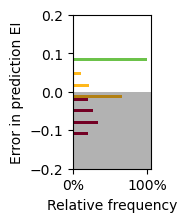

In [32]:
" Change vs change: annual precipitation"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -20
change2 = 20
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='Pa'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2 
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'Pa_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


### Evaporation

0 2 23
5.713094231835498
29.160758204758167


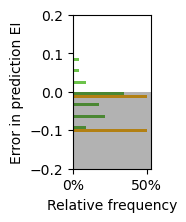

In [33]:
" Change vs change: annual evaporation"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -10
change2 = 10
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='Epa'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2   
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                des_change_total.append(des_change)
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


0 5 20
-0.08909641345080388
0.586198184404493


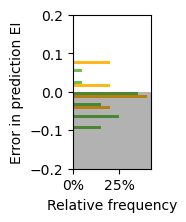

In [34]:
" Change vs change: Temperature"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.2
change2 = 0.2
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='T'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                des_change_total.append(des_change)
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


### Interstorm duration

11 11 3
-0.4450278510061949
0.3275106261075802


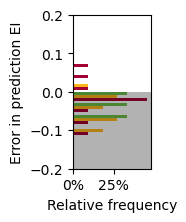

In [35]:
" Change vs change: interstorm duration"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.1
change2 = 0.1
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='is_dur'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2   
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                des_change_total.append(des_change)
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


### Seasonality index

0 13 10


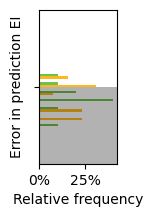

In [36]:
" Change vs change: Seasonality index"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.02
change2 = 0.02
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='SI'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2   
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                des_change_total.append(des_change)
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
                        
EI_dev1 = ''
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)


             
for a in range(3):
    if EI_dev[a] != 0 and EI_dev[a] != '':
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/SI_change.png')   


### Seasonality Timing

0 12 12


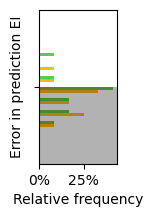

In [37]:
" Change vs change: Seasonality Timing"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.02
change2 = 0.02
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='ST'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2   
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
                        
EI_dev1 = ''
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)


             
for a in range(3):
    if EI_dev[a] != 0 and EI_dev[a] != '':
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/ST_change.png')   


In [ ]:
print(meuse_names_be)

for k in range(len(descriptors)):
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(5)
    fig.set_figwidth(7)
    
    EI_dev_total = []
    des_change_total = []
    
    catchment_list = meuse_names_fr
    df_output = df_output_fr
    yrsl = yrsl_fr
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                plt.plot(df_output[f'{descriptors[k]}_change {yrsl[j]}'], df_output[f'EI deviation {yrsl[j]}'], '.', c=colors[j])
                
    catchment_list = meuse_names_be2
    df_output = df_output_be
    yrsl = yrsl_be
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                plt.plot(df_output[f'{descriptors[k]}_change {yrsl[j]}'], df_output[f'EI deviation {yrsl[j]}'], '.', c='#95bb72')                 

    x = des_change_total
    y = EI_dev_total
    
    pearson = pearsonr(x, y)
    m, b = np.polyfit(x, y, 1)
    pearsony = np.zeros(len(x))
    
    for q in range(len(EI_dev_total)):
        pearsony[q] = m * x[q] + b
    axs.plot(x, pearsony, 'k')
                
        
    axs.set_xlabel(f"Change in {descriptors_names[k]}")
    axs.set_ylabel(f"Devation Evaporative Index")
    axs.set_title(f"Meuse {descriptors_names[k]}")
    
    
    legend = [
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[1]}',
                       markerfacecolor=f'{colors[1]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[2]}',
                       markerfacecolor=f'{colors[2]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[3]}',
                       markerfacecolor=f'{colors[3]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'Belgium {yrsl_be[1]}',
                       markerfacecolor='#95bb72', markersize=15),
            Line2D([0], [0], color='k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" ,
                       markerfacecolor='k', markersize=10)]                    

    axs.legend(handles=legend,loc='lower right')
                
    plt.savefig(f'2_Output/{output}/Results/Change_total_time_{descriptors_names[k]}.png')   
    plt.close()

### BE - EI expected

In [ ]:
df_output = df_output_be
yrsl = yrsl_be
catchment_list = meuse_names_be2
yrcut = yrcut_be


for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    # if name == "Salzinnes":
    #     name = "Salzinnes Ronet"
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area

    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    if AI < EI or Ea <0:
        print(f'Exclude catchment with ID {catchment_list[i]}')            
    
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['dt']).year  
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)

        
            
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}')]

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/BE/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)

### FR - EI expected

In [ ]:
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
df_output = pd.DataFrame(index=catchment_list)

yrsl = yrsl_fr

for i in range(len(catchment_list)):
    name = fr_dict_code[st[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == st[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]
    # display(data)

       
#     # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    T = data['temp_subcatch'].mean()
    
#     #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    print(catchment_list[i], EI, AI)
    if AI < EI or Ea < 0:
        print(f'Exclude catchment with ID {catchment_list[i]}')
    
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'FR {name}', fontsize = 20)

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
                             
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize =5)
            
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)

        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w                    
    
        
        axs[0].legend(loc='lower right')
        plt.savefig(f'2_Output/{output}/Catchments/FR/Budyko_and_deficits_of_catchment_{name}.png')  
        
    plt.close(fig)
    
print("end loop")

df_output_fr = df_output

In [ ]:
plt.figure(figsize=(10,5)).suptitle("Meuse data (n=31)",fontsize=20)
plt.ylabel("Actual ET/P")
plt.xlabel("Potential ET/P")
n = 0

budyko_curve_x = np.arange(1, 3, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)

water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')

df_omega = pd.DataFrame(index=meuse_names_be)
colors = ['#9FB2FF', '#496AFF', '#0020AF']
yrs = ['1996-2005', '2006-2015']

for i in range(len(meuse_names_be2)):
    data = pd.read_csv("1_Data/final_names/"+str(meuse_names_be[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = meuse_names_be[i].strip()
    nameupper = name.upper()
    
    
    if catchment_list[i] == 'Maastricht':
        dataq = pd.read_excel("1_Data/SPW_names/SPW_Q_MAASTRICHT.xlsx")
        dataq.columns = ['dt', 'Q']
        dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
        dataq.index = dataq['dt']
        are = df_area[df_area['Station']== name]
        area = are['area_m2'].item()
        # dataq_day["hour"] = dataq["Q"] * 3600
        # dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
        display(dataq)

    else:
            # Read Belgian data        
        dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        # display(dataq)
        dataq.columns = ['dt', 'Q']
        dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
        dataq.index = dataq['dt']

        are = df_area[df_area['Station']== name]
        area = are['area_m2'].item()

        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area


        # get the right dates (1996 - 2016)
        data = data.loc["1996-01-01":"2016-12-31"]
        data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    
    plt.ylabel("Actual ET/P")
    plt.xlabel("Potential ET/P")
    plt.plot(AI, EI, marker=".", c = '#95bb72')
            
# plt.legend(['Belgium', 'France'])

red_patch = Patch(color='#95bb72', label='Belgium')
blue_patch = Patch(color='blue', label='France')
plt.legend(handles=[red_patch, blue_patch])

print(f'n with france and beglian data data is {n}')
plt.savefig(f'2_Output/{output}/Budyko7.png')   

In [ ]:
"Deze is gekopieerd uit andere script maar werkt niet"

plt.figure(figsize=(10,5)).suptitle("Meuse data",fontsize=20)
plt.ylabel("Actual ET/P")
plt.xlabel("Potential ET/P")


budyko_curve_x = np.arange(1, 3, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)

water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')


for code in range(len(meuse_names_fr_total):
    name = fr_dict_code[code]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == code]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"]/ area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]    
    
    # plot budyko
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
        
    #Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  # actual evaporation
    AI = Ep / P   # aridity index
    EI = Ea / P # evaporative index
        
print(f'n with only france data is {n}')

df_omega = pd.DataFrame(index=meuse_names_be)
colors = ['#9FB2FF', '#496AFF', '#0020AF']
yrs = ['1996-2005', '2006-2015']

# Load belgian data

for i in range(len(meuse_names_be)):
    data = pd.read_csv("1_Data/final_names/"+str(meuse_names_be[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = meuse_names_be[i].strip()
    nameupper = name.upper()
            
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    
    if Ea > 0 and AI > EI: 
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.plot(AI, EI, marker=".", c = '#95bb72')
        n+=1
        
# plt.legend(['Belgium', 'France'])

red_patch = Patch(color='#95bb72', label='Belgium')
blue_patch = Patch(color='blue', label='France')
plt.legend(handles=[red_patch, blue_patch])

print(f'n with france and beglian data data is {n}')
plt.savefig(f'2_Output/{output}/Budyko7.png')   

In [ ]:
catchment_list = meuse_names_fr_total
stations = stations_total
yrsl = yrsl_fr
yrcut = yrcut_fr
color = iter(cm.rainbow(np.linspace(0, 1, 34)))
warnings.filterwarnings('ignore')


plt.figure(figsize=(10,5)).suptitle("Meuse data",fontsize=20)
plt.ylabel("Actual ET/P")
plt.xlabel("Potential ET/P")

budyko_curve_x = np.arange(1, 3, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)

water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')


for i in range(len(catchment_list)):
    c = next(color)
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]
    # display(data)

       
#     # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    T = data['temp_subcatch'].mean()
    
#     #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P

    plt.plot(AI, EI, marker="o", c=c, label=catchment_list[i], markeredgecolor='k')
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.plot(AI, EI, marker=".", c=c)


catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be


for i in range(len(catchment_list)):
    c = next(color)
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']

        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P      
    
    plt.plot(AI, EI, marker="o", c=c, label=catchment_list[i], markeredgecolor='k')

    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        yearslice = yrsl[j]      
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()
        

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.plot(AI, EI, marker=".", c=c)
        
        
plt.savefig(f'2_Output/{output}/Budyko3.png')   